# **Predictive Analytics: Shinkansen Passenger Satisfaction**

## Data Preprocessing

**1. Import necessary libraries**

In [85]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.simplefilter("ignore")

**2. Load the training and test data separately**

In [3]:
#train data
surveydata_train = pd.read_csv("Surveydata_train.csv")
traveldata_train = pd.read_csv("Traveldata_train.csv")
#test data
surveydata_test = pd.read_csv("Surveydata_test.csv")
traveldata_test = pd.read_csv("Traveldata_test.csv")

**3. Understand the data (check for each of the following in both the train and test dataset)**
<ol>
<li>Check a sample of the data</li>
<li>Use the info() and describe() functions for more information</li>
<li>Look for the presence of null values in the dataset</li>
<li>Look for the presence of bad data or unwanted characters like "$" or "#" in the numerical columns</li>
</ol>

In [4]:
#A. Check a sample of the data
surveydata_train.sample(5)

,ID,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
68675,98868676,0,Poor,Ordinary,Needs Improvement,Poor,Needs Improvement,Needs Improvement,Poor,Needs Improvement,Needs Improvement,Acceptable,Acceptable,Needs Improvement,Good,Acceptable,Needs Improvement
36061,98836062,1,Good,Ordinary,Needs Improvement,Needs Improvement,Needs Improvement,Good,Good,Good,Good,Poor,Good,Needs Improvement,Excellent,Poor,Good
88843,98888844,1,Good,Green Car,Good,Good,Convenient,Good,Good,Good,Good,Acceptable,Excellent,Poor,Good,Needs Improvement,Good
57840,98857841,1,Good,Green Car,Poor,Acceptable,Manageable,Good,Good,Good,Good,Excellent,Acceptable,Excellent,Good,Needs Improvement,Good
70269,98870270,1,Poor,Ordinary,Poor,Poor,Inconvenient,Acceptable,Excellent,Good,Good,Good,Excellent,Good,Excellent,Good,Good


In [5]:
#A. Check a sample of the data
traveldata_train.sample(5)

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
93683,98893684,Male,Loyal Customer,27.0,Business Travel,Eco,1255,2.0,0.0
50768,98850769,Female,Loyal Customer,26.0,Personal Travel,Eco,3317,0.0,0.0
48747,98848748,Male,NaN,29.0,Business Travel,Eco,2115,20.0,16.0
83971,98883972,Male,Loyal Customer,22.0,Personal Travel,Eco,1268,36.0,72.0
55949,98855950,Male,Loyal Customer,47.0,Personal Travel,Eco,2238,0.0,0.0


In [6]:
#B. Use the info() and describe() functions for more information
surveydata_train.info()
surveydata_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       94379 non-null  int64 
 1   Overall_Experience       94379 non-null  int64 
 2   Seat_Comfort             94318 non-null  object
 3   Seat_Class               94379 non-null  object
 4   Arrival_Time_Convenient  85449 non-null  object
 5   Catering                 85638 non-null  object
 6   Platform_Location        94349 non-null  object
 7   Onboard_Wifi_Service     94349 non-null  object
 8   Onboard_Entertainment    94361 non-null  object
 9   Online_Support           94288 non-null  object
 10  Ease_of_Online_Booking   94306 non-null  object
 11  Onboard_Service          86778 non-null  object
 12  Legroom                  94289 non-null  object
 13  Baggage_Handling         94237 non-null  object
 14  CheckIn_Service          94302 non-nul

,ID,Overall_Experience
count,9.437900e+04,94379.000000
mean,9.884719e+07,0.546658
std,2.724501e+04,0.497821
min,9.880000e+07,0.000000
25%,9.882360e+07,0.000000
50%,9.884719e+07,1.000000
75%,9.887078e+07,1.000000
max,9.889438e+07,1.000000


In [7]:
#B. Use the info() and describe() functions for more information
traveldata_train.info()
traveldata_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94379 entries, 0 to 94378
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.5+ MB


,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
count,9.437900e+04,94346.000000,94379.000000,94322.000000,94022.000000
mean,9.884719e+07,39.419647,1978.888185,14.647092,15.005222
std,2.724501e+04,15.116632,1027.961019,38.138781,38.439409
min,9.880000e+07,7.000000,50.000000,0.000000,0.000000
25%,9.882360e+07,27.000000,1359.000000,0.000000,0.000000
50%,9.884719e+07,40.000000,1923.000000,0.000000,0.000000
75%,9.887078e+07,51.000000,2538.000000,12.000000,13.000000
max,9.889438e+07,85.000000,6951.000000,1592.000000,1584.000000


In [8]:
#C. Look for the presence of null values in the dataset
surveydata_train.isnull().values.any()

True

In [9]:
#C. Look for the presence of null values in the dataset
traveldata_train.isnull().values.any()

True

In [10]:
#D. Look for the presence of bad data or unwanted characters like "$" or "#" in the numerical columns
surveydata_train.describe().columns.astype(str).str.contains("($|#)").any()

True

In [11]:
#D. Look for the presence of bad data or unwanted characters like "$" or "#" in the numerical columns
traveldata_train.describe().columns.astype(str).str.contains("($|#)").any()

True

**4. Clean the data**
<ol>
<li>Treat for missing values in both the train & test set</li>
<li>Remove bad data values in both the train & test set</li>
<li>Encode the categorical object variables in both the train & test set</li>
<li>Perform Feature Engineering if necessary</li>
<li>Scale/Normalize the dataset if necessary</li>
</ol>

In [12]:
def dataframe_cleaning(df):
    # Before cleaning any data, it is important to transform Categorical values to numerical values
    # Retrieve categorical columns, which have data type as "object"
    df_object_columns = df.select_dtypes(include=['object']).columns
    # One-hot encoding for categorical variables
    df_encoded = pd.get_dummies(df, columns=df_object_columns, dummy_na=True)
    #A. Treat for missing values in both the train & test set
    imputer = KNNImputer(n_neighbors=15, 
                         weights='uniform', 
                         metric='nan_euclidean', 
                         missing_values=np.nan, 
                         add_indicator=False)
    #np array is created
    df_imputed = imputer.fit_transform(df_encoded)
    #back to dataframe
    df_without_nans = pd.DataFrame(data=df_imputed, columns=df_encoded.columns)
    
    return df_without_nans

In [13]:
#train data
surveydata_train_clean = dataframe_cleaning(surveydata_train)
traveldata_train_clean = dataframe_cleaning(traveldata_train)
#test data
surveydata_test_clean = dataframe_cleaning(surveydata_test)
traveldata_test_clean = dataframe_cleaning(traveldata_test)

In [14]:
#if a column is not present on the test set, then it is not important in the train set. Sans the target variable "Overall_Experience"
def shape_equalizer(df1, df2):
    """train, then test"""
    df1_columns = df1.columns
    df2_columns = df2.columns
    difference = list(set(df1_columns).difference(set(df2_columns)))
    if "Overall_Experience" in difference:
        difference.pop(difference.index("Overall_Experience"))
    df1 = df1.drop(difference, axis=1)
    return df1, df2

In [15]:
#survey data
surveydata_train_equalized, surveydata_test_equalized = shape_equalizer(surveydata_train_clean, surveydata_test_clean)
#travel data
traveldata_train_equalized, traveldata_test_equalized = shape_equalizer(traveldata_train_clean, traveldata_test_clean)

In [16]:
if surveydata_train_equalized.shape[0] == traveldata_train_equalized.shape[0] and surveydata_test_equalized.shape[0] == traveldata_test_equalized.shape[0]:
    print("Same number of rows between survey and travel data sets.")

Same number of rows between survey and travel data sets.


In [17]:
# -1 due to target column "Overall_Experience"
if surveydata_train_equalized.shape[1]-1 == surveydata_test_equalized.shape[1] and traveldata_train_equalized.shape[1] == traveldata_test_equalized.shape[1]:
    print("Same number of columns between test and train data sets.")

Same number of columns between test and train data sets.


In [18]:
#last, join the two datasets for train and the two datasets for test
#train
train_data = traveldata_train_equalized.merge(surveydata_train_equalized, on='ID')
#test
test_data = traveldata_test_equalized.merge(surveydata_test_equalized, on='ID')

## Model Building

In [19]:
# train, test, split for all
X = train_data.drop('Overall_Experience', axis=1)
y = train_data['Overall_Experience']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# save function for all
def results_to_csv(y_pred, var_name):
    data = test_data.copy()
    data['Overall_Experience'] = y_pred
    result = data[['ID', 'Overall_Experience']]
    #to integers
    result[['ID', 'Overall_Experience']] = result[['ID', 'Overall_Experience']].astype(int)
    #print head
    print(result.head(5))
    #save as csv
    name = "_".join(var_name.split('_')[-2:]) + '_result.csv'
    return result.to_csv(name, index=False)

### catboost

In [ ]:
# Fit the model
# CatBoostError: only one of the parameters iterations, n_estimators, num_boost_round, num_trees should be initialized.
cat = make_pipeline(
    StandardScaler(), 
    CatBoostClassifier(n_estimators=4000,#iterations=4000,
                       depth=12, 
                       learning_rate=0.02, 
                       loss_function='CrossEntropy',
                       verbose=2,
                       random_seed=42,
                       thread_count=-1)
)

cat.fit(X_train, y_train)

In [ ]:
# Train the model
y_pred_train_cat = cat.predict(X_train)

In [ ]:
# Evaluate model on training data
print(confusion_matrix(y_train, y_pred_train_cat))

In [ ]:
# Make predictions on validation data
y_pred_val_extra_trees = cat.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val_extra_trees)
#pretty plot
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels (depends on your problem)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [ ]:
[[TN,FP],[FN,TP]] = cm
Accuracy = (TN + TP) / (TN + FP + FN + TP)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = 2 * (Precision * Recall) / (Precision + Recall)
maybe_acc = Accuracy - 0.003
target = 0.9576428
print(f"cm:\n{cm}\nAccuracy:\t{Accuracy:.7f}\nPrecision:\t{Precision:.7f}\nRecall:\t\t{Recall:.7f}\nF1_score:\t{F1_score:.7f}\n\nMaybe Acc:\t{maybe_acc:.7f}\nTarget:\t\t{target:.7f}")


In [ ]:
# Make prediction
y_pred_test_cat_boost = cat.predict(test_data)
y_pred_test_cat_boost


In [ ]:
results_to_csv(y_pred_test_cat_boost, "y_pred_test_cat_boost")


## Best model

In [24]:
from sklearn.experimental import enable_halving_search_cv  # explicitly require this experimental feature
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.base import BaseEstimator

# Define the parameter grid
first_param_grid = {
    'n_estimators': [3000, 3500, 4000],
    'depth': [8, 10, 12],
    'learning_rate' : [0.03, 0.1, 0.2]
}
#best_params results were {'depth': 8, 'learning_rate': 0.03, 'n_estimators': 4000}
#thus a modification ensues
second_param_grid = {
    'n_estimators': [4000, 4500, 5000],
    'depth': [7, 8, 9],
    'learning_rate' : [0.01, 0.02, 0.03]
}
#best_params results were {'depth': 8, 'learning_rate': 0.01, 'n_estimators': 5000}
#thus another modification ensues
second_param_grid = {
    'n_estimators': [5000, 6000, 7000],
    'learning_rate' : [0.01, 0.005, 0.001]
}

class CatBoostClassifierWithEarlyStopping(CatBoostClassifier):
    def fit(self, X, y, **fit_params):
        if 'eval_set' not in fit_params:
            raise ValueError("`eval_set` must be provided for early stopping")
        super().fit(X, y, early_stopping_rounds=10, **fit_params)
        return self

# Define your custom classifier
catb = CatBoostClassifierWithEarlyStopping()

# Make sure to pass the validation set as `eval_set` when fitting
halving_search = HalvingGridSearchCV(estimator = catb,
                                     param_grid = param_grid,
                                     cv = 4,
                                     scoring='accuracy',
                                     resource='n_samples',
                                     max_resources='auto',
                                     factor=2,
                                     n_jobs = -1,
                                     verbose = 2)

# Fit the grid search to the data
halving_search.fit(X_train, y_train, eval_set=(X_val, y_val))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 4718
max_resources_: 75503
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 27
n_resources: 4718
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 1
n_candidates: 14
n_resources: 9436
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 2
n_candidates: 7
n_resources: 18872
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 3
n_candidates: 4
n_resources: 37744
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 4
n_candidates: 2
n_resources: 75488
Fitting 3 folds for each of 2 candidates, totalling 6 fits
0:	learn: 0.6800600	test: 0.6800604	best: 0.6800604 (0)	total: 19.8ms	remaining: 1m 38s
1:	learn: 0.6675425	test: 0.6675260	best: 0.6675260 (1)	total: 38.5ms	remaining: 1m 36s
2:	learn: 0.6552898	test: 0.6552874	best: 0.6552874 (2)	total: 56.2ms	remaining: 1m 33s
3:	learn: 0.6435

87:	learn: 0.2810963	test: 0.2807548	best: 0.2807548 (87)	total: 1.95s	remaining: 1m 48s
88:	learn: 0.2798934	test: 0.2795443	best: 0.2795443 (88)	total: 1.97s	remaining: 1m 48s
89:	learn: 0.2785206	test: 0.2781556	best: 0.2781556 (89)	total: 1.99s	remaining: 1m 48s
90:	learn: 0.2768940	test: 0.2765428	best: 0.2765428 (90)	total: 2.02s	remaining: 1m 48s
91:	learn: 0.2752179	test: 0.2748741	best: 0.2748741 (91)	total: 2.04s	remaining: 1m 48s
92:	learn: 0.2732133	test: 0.2728639	best: 0.2728639 (92)	total: 2.06s	remaining: 1m 48s
93:	learn: 0.2718423	test: 0.2714771	best: 0.2714771 (93)	total: 2.08s	remaining: 1m 48s
94:	learn: 0.2701528	test: 0.2698140	best: 0.2698140 (94)	total: 2.1s	remaining: 1m 48s
95:	learn: 0.2686394	test: 0.2683077	best: 0.2683077 (95)	total: 2.12s	remaining: 1m 48s
96:	learn: 0.2676051	test: 0.2672768	best: 0.2672768 (96)	total: 2.14s	remaining: 1m 48s
97:	learn: 0.2665427	test: 0.2662398	best: 0.2662398 (97)	total: 2.16s	remaining: 1m 48s
98:	learn: 0.2650706	t

179:	learn: 0.2004708	test: 0.2013103	best: 0.2013103 (179)	total: 3.86s	remaining: 1m 43s
180:	learn: 0.2001829	test: 0.2010534	best: 0.2010534 (180)	total: 3.88s	remaining: 1m 43s
181:	learn: 0.1998621	test: 0.2007524	best: 0.2007524 (181)	total: 3.91s	remaining: 1m 43s
182:	learn: 0.1992234	test: 0.2001197	best: 0.2001197 (182)	total: 3.93s	remaining: 1m 43s
183:	learn: 0.1986135	test: 0.1995096	best: 0.1995096 (183)	total: 3.95s	remaining: 1m 43s
184:	learn: 0.1981438	test: 0.1990403	best: 0.1990403 (184)	total: 3.97s	remaining: 1m 43s
185:	learn: 0.1977614	test: 0.1986508	best: 0.1986508 (185)	total: 3.99s	remaining: 1m 43s
186:	learn: 0.1972655	test: 0.1981957	best: 0.1981957 (186)	total: 4.01s	remaining: 1m 43s
187:	learn: 0.1969090	test: 0.1978724	best: 0.1978724 (187)	total: 4.03s	remaining: 1m 43s
188:	learn: 0.1962994	test: 0.1972728	best: 0.1972728 (188)	total: 4.05s	remaining: 1m 43s
189:	learn: 0.1957871	test: 0.1967600	best: 0.1967600 (189)	total: 4.07s	remaining: 1m 42s

274:	learn: 0.1680969	test: 0.1700385	best: 0.1700385 (274)	total: 5.84s	remaining: 1m 40s
275:	learn: 0.1677827	test: 0.1697470	best: 0.1697470 (275)	total: 5.86s	remaining: 1m 40s
276:	learn: 0.1675181	test: 0.1695024	best: 0.1695024 (276)	total: 5.88s	remaining: 1m 40s
277:	learn: 0.1672770	test: 0.1692847	best: 0.1692847 (277)	total: 5.9s	remaining: 1m 40s
278:	learn: 0.1668637	test: 0.1688646	best: 0.1688646 (278)	total: 5.92s	remaining: 1m 40s
279:	learn: 0.1665150	test: 0.1685310	best: 0.1685310 (279)	total: 5.93s	remaining: 1m 40s
280:	learn: 0.1663536	test: 0.1683743	best: 0.1683743 (280)	total: 5.96s	remaining: 1m 40s
281:	learn: 0.1662194	test: 0.1682578	best: 0.1682578 (281)	total: 5.98s	remaining: 1m 40s
282:	learn: 0.1659004	test: 0.1679479	best: 0.1679479 (282)	total: 6s	remaining: 1m 40s
283:	learn: 0.1657195	test: 0.1677714	best: 0.1677714 (283)	total: 6.02s	remaining: 1m 39s
284:	learn: 0.1655141	test: 0.1675811	best: 0.1675811 (284)	total: 6.04s	remaining: 1m 39s
285

368:	learn: 0.1505877	test: 0.1535860	best: 0.1535860 (368)	total: 7.73s	remaining: 1m 37s
369:	learn: 0.1504724	test: 0.1535001	best: 0.1535001 (369)	total: 7.75s	remaining: 1m 37s
370:	learn: 0.1503522	test: 0.1533811	best: 0.1533811 (370)	total: 7.78s	remaining: 1m 37s
371:	learn: 0.1501790	test: 0.1532022	best: 0.1532022 (371)	total: 7.8s	remaining: 1m 37s
372:	learn: 0.1500816	test: 0.1531094	best: 0.1531094 (372)	total: 7.82s	remaining: 1m 36s
373:	learn: 0.1498558	test: 0.1528875	best: 0.1528875 (373)	total: 7.84s	remaining: 1m 36s
374:	learn: 0.1497804	test: 0.1528306	best: 0.1528306 (374)	total: 7.86s	remaining: 1m 36s
375:	learn: 0.1495668	test: 0.1526285	best: 0.1526285 (375)	total: 7.88s	remaining: 1m 36s
376:	learn: 0.1495061	test: 0.1525850	best: 0.1525850 (376)	total: 7.9s	remaining: 1m 36s
377:	learn: 0.1493625	test: 0.1524514	best: 0.1524514 (377)	total: 7.92s	remaining: 1m 36s
378:	learn: 0.1491318	test: 0.1522169	best: 0.1522169 (378)	total: 7.94s	remaining: 1m 36s
3

467:	learn: 0.1382818	test: 0.1423562	best: 0.1423562 (467)	total: 9.67s	remaining: 1m 33s
468:	learn: 0.1382271	test: 0.1423143	best: 0.1423143 (468)	total: 9.69s	remaining: 1m 33s
469:	learn: 0.1381379	test: 0.1422284	best: 0.1422284 (469)	total: 9.71s	remaining: 1m 33s
470:	learn: 0.1380729	test: 0.1421685	best: 0.1421685 (470)	total: 9.72s	remaining: 1m 33s
471:	learn: 0.1379779	test: 0.1420751	best: 0.1420751 (471)	total: 9.74s	remaining: 1m 33s
472:	learn: 0.1379179	test: 0.1420165	best: 0.1420165 (472)	total: 9.76s	remaining: 1m 33s
473:	learn: 0.1378128	test: 0.1419166	best: 0.1419166 (473)	total: 9.78s	remaining: 1m 33s
474:	learn: 0.1377626	test: 0.1418791	best: 0.1418791 (474)	total: 9.8s	remaining: 1m 33s
475:	learn: 0.1376393	test: 0.1417750	best: 0.1417750 (475)	total: 9.81s	remaining: 1m 33s
476:	learn: 0.1375052	test: 0.1416505	best: 0.1416505 (476)	total: 9.83s	remaining: 1m 33s
477:	learn: 0.1373331	test: 0.1414893	best: 0.1414893 (477)	total: 9.85s	remaining: 1m 33s


563:	learn: 0.1294307	test: 0.1345099	best: 0.1345099 (563)	total: 11.3s	remaining: 1m 29s
564:	learn: 0.1293099	test: 0.1343953	best: 0.1343953 (564)	total: 11.4s	remaining: 1m 29s
565:	learn: 0.1292251	test: 0.1343164	best: 0.1343164 (565)	total: 11.4s	remaining: 1m 29s
566:	learn: 0.1291478	test: 0.1342362	best: 0.1342362 (566)	total: 11.4s	remaining: 1m 29s
567:	learn: 0.1290352	test: 0.1341382	best: 0.1341382 (567)	total: 11.4s	remaining: 1m 29s
568:	learn: 0.1289753	test: 0.1340863	best: 0.1340863 (568)	total: 11.4s	remaining: 1m 29s
569:	learn: 0.1288949	test: 0.1340126	best: 0.1340126 (569)	total: 11.5s	remaining: 1m 29s
570:	learn: 0.1288542	test: 0.1339688	best: 0.1339688 (570)	total: 11.5s	remaining: 1m 28s
571:	learn: 0.1287445	test: 0.1338622	best: 0.1338622 (571)	total: 11.5s	remaining: 1m 28s
572:	learn: 0.1286737	test: 0.1338141	best: 0.1338141 (572)	total: 11.5s	remaining: 1m 28s
573:	learn: 0.1286101	test: 0.1337616	best: 0.1337616 (573)	total: 11.5s	remaining: 1m 28s

660:	learn: 0.1217268	test: 0.1277019	best: 0.1277019 (660)	total: 13.1s	remaining: 1m 25s
661:	learn: 0.1216754	test: 0.1276693	best: 0.1276693 (661)	total: 13.1s	remaining: 1m 25s
662:	learn: 0.1215980	test: 0.1275899	best: 0.1275899 (662)	total: 13.1s	remaining: 1m 25s
663:	learn: 0.1215497	test: 0.1275537	best: 0.1275537 (663)	total: 13.1s	remaining: 1m 25s
664:	learn: 0.1214376	test: 0.1274636	best: 0.1274636 (664)	total: 13.1s	remaining: 1m 25s
665:	learn: 0.1213535	test: 0.1273870	best: 0.1273870 (665)	total: 13.2s	remaining: 1m 25s
666:	learn: 0.1213231	test: 0.1273604	best: 0.1273604 (666)	total: 13.2s	remaining: 1m 25s
667:	learn: 0.1212683	test: 0.1273273	best: 0.1273273 (667)	total: 13.2s	remaining: 1m 25s
668:	learn: 0.1212065	test: 0.1272796	best: 0.1272796 (668)	total: 13.2s	remaining: 1m 25s
669:	learn: 0.1211299	test: 0.1272169	best: 0.1272169 (669)	total: 13.2s	remaining: 1m 25s
670:	learn: 0.1210756	test: 0.1271749	best: 0.1271749 (670)	total: 13.2s	remaining: 1m 25s

756:	learn: 0.1160917	test: 0.1231031	best: 0.1231031 (756)	total: 15s	remaining: 1m 24s
757:	learn: 0.1160267	test: 0.1230529	best: 0.1230529 (757)	total: 15s	remaining: 1m 24s
758:	learn: 0.1159318	test: 0.1229597	best: 0.1229597 (758)	total: 15s	remaining: 1m 24s
759:	learn: 0.1158822	test: 0.1229171	best: 0.1229171 (759)	total: 15.1s	remaining: 1m 24s
760:	learn: 0.1158385	test: 0.1228810	best: 0.1228810 (760)	total: 15.1s	remaining: 1m 24s
761:	learn: 0.1158114	test: 0.1228709	best: 0.1228709 (761)	total: 15.1s	remaining: 1m 24s
762:	learn: 0.1157618	test: 0.1228227	best: 0.1228227 (762)	total: 15.1s	remaining: 1m 24s
763:	learn: 0.1157363	test: 0.1228117	best: 0.1228117 (763)	total: 15.2s	remaining: 1m 24s
764:	learn: 0.1156895	test: 0.1227799	best: 0.1227799 (764)	total: 15.2s	remaining: 1m 24s
765:	learn: 0.1156241	test: 0.1227214	best: 0.1227214 (765)	total: 15.2s	remaining: 1m 23s
766:	learn: 0.1155925	test: 0.1227052	best: 0.1227052 (766)	total: 15.2s	remaining: 1m 23s
767:	

854:	learn: 0.1109794	test: 0.1190728	best: 0.1190728 (854)	total: 16.9s	remaining: 1m 22s
855:	learn: 0.1109489	test: 0.1190575	best: 0.1190575 (855)	total: 16.9s	remaining: 1m 22s
856:	learn: 0.1108883	test: 0.1190100	best: 0.1190100 (856)	total: 17s	remaining: 1m 21s
857:	learn: 0.1107978	test: 0.1189303	best: 0.1189303 (857)	total: 17s	remaining: 1m 21s
858:	learn: 0.1107433	test: 0.1188914	best: 0.1188914 (858)	total: 17s	remaining: 1m 21s
859:	learn: 0.1106557	test: 0.1188044	best: 0.1188044 (859)	total: 17s	remaining: 1m 21s
860:	learn: 0.1105739	test: 0.1187226	best: 0.1187226 (860)	total: 17s	remaining: 1m 21s
861:	learn: 0.1105362	test: 0.1186949	best: 0.1186949 (861)	total: 17.1s	remaining: 1m 21s
862:	learn: 0.1104532	test: 0.1186254	best: 0.1186254 (862)	total: 17.1s	remaining: 1m 21s
863:	learn: 0.1104223	test: 0.1186009	best: 0.1186009 (863)	total: 17.1s	remaining: 1m 21s
864:	learn: 0.1103730	test: 0.1185621	best: 0.1185621 (864)	total: 17.1s	remaining: 1m 21s
865:	lear

951:	learn: 0.1069016	test: 0.1159393	best: 0.1159393 (951)	total: 18.7s	remaining: 1m 19s
952:	learn: 0.1068675	test: 0.1159132	best: 0.1159132 (952)	total: 18.7s	remaining: 1m 19s
953:	learn: 0.1068058	test: 0.1158650	best: 0.1158650 (953)	total: 18.7s	remaining: 1m 19s
954:	learn: 0.1067737	test: 0.1158429	best: 0.1158429 (954)	total: 18.7s	remaining: 1m 19s
955:	learn: 0.1067468	test: 0.1158360	best: 0.1158360 (955)	total: 18.7s	remaining: 1m 19s
956:	learn: 0.1067092	test: 0.1158087	best: 0.1158087 (956)	total: 18.7s	remaining: 1m 19s
957:	learn: 0.1066771	test: 0.1157898	best: 0.1157898 (957)	total: 18.8s	remaining: 1m 19s
958:	learn: 0.1066433	test: 0.1157647	best: 0.1157647 (958)	total: 18.8s	remaining: 1m 19s
959:	learn: 0.1066145	test: 0.1157425	best: 0.1157425 (959)	total: 18.8s	remaining: 1m 19s
960:	learn: 0.1065897	test: 0.1157316	best: 0.1157316 (960)	total: 18.8s	remaining: 1m 19s
961:	learn: 0.1065409	test: 0.1156966	best: 0.1156966 (961)	total: 18.8s	remaining: 1m 19s

1050:	learn: 0.1034539	test: 0.1135496	best: 0.1135496 (1050)	total: 20.4s	remaining: 1m 16s
1051:	learn: 0.1034346	test: 0.1135428	best: 0.1135428 (1051)	total: 20.4s	remaining: 1m 16s
1052:	learn: 0.1034042	test: 0.1135204	best: 0.1135204 (1052)	total: 20.4s	remaining: 1m 16s
1053:	learn: 0.1033827	test: 0.1135092	best: 0.1135092 (1053)	total: 20.5s	remaining: 1m 16s
1054:	learn: 0.1033455	test: 0.1134813	best: 0.1134813 (1054)	total: 20.5s	remaining: 1m 16s
1055:	learn: 0.1033266	test: 0.1134652	best: 0.1134652 (1055)	total: 20.5s	remaining: 1m 16s
1056:	learn: 0.1033033	test: 0.1134445	best: 0.1134445 (1056)	total: 20.5s	remaining: 1m 16s
1057:	learn: 0.1032817	test: 0.1134412	best: 0.1134412 (1057)	total: 20.5s	remaining: 1m 16s
1058:	learn: 0.1032633	test: 0.1134312	best: 0.1134312 (1058)	total: 20.6s	remaining: 1m 16s
1059:	learn: 0.1032342	test: 0.1134112	best: 0.1134112 (1059)	total: 20.6s	remaining: 1m 16s
1060:	learn: 0.1032033	test: 0.1133920	best: 0.1133920 (1060)	total: 2

1139:	learn: 0.1005684	test: 0.1116438	best: 0.1116438 (1139)	total: 21.9s	remaining: 1m 14s
1140:	learn: 0.1005368	test: 0.1116288	best: 0.1116288 (1140)	total: 21.9s	remaining: 1m 14s
1141:	learn: 0.1005148	test: 0.1116150	best: 0.1116150 (1141)	total: 22s	remaining: 1m 14s
1142:	learn: 0.1004790	test: 0.1115953	best: 0.1115953 (1142)	total: 22s	remaining: 1m 14s
1143:	learn: 0.1004490	test: 0.1115680	best: 0.1115680 (1143)	total: 22s	remaining: 1m 14s
1144:	learn: 0.1004185	test: 0.1115494	best: 0.1115494 (1144)	total: 22s	remaining: 1m 14s
1145:	learn: 0.1003965	test: 0.1115373	best: 0.1115373 (1145)	total: 22s	remaining: 1m 14s
1146:	learn: 0.1003629	test: 0.1115136	best: 0.1115136 (1146)	total: 22s	remaining: 1m 14s
1147:	learn: 0.1003280	test: 0.1114902	best: 0.1114902 (1147)	total: 22.1s	remaining: 1m 13s
1148:	learn: 0.1003118	test: 0.1114758	best: 0.1114758 (1148)	total: 22.1s	remaining: 1m 13s
1149:	learn: 0.1002959	test: 0.1114673	best: 0.1114673 (1149)	total: 22.1s	remaini

1229:	learn: 0.0982058	test: 0.1101924	best: 0.1101924 (1229)	total: 23.4s	remaining: 1m 11s
1230:	learn: 0.0981916	test: 0.1101885	best: 0.1101885 (1230)	total: 23.4s	remaining: 1m 11s
1231:	learn: 0.0981631	test: 0.1101635	best: 0.1101635 (1231)	total: 23.4s	remaining: 1m 11s
1232:	learn: 0.0981404	test: 0.1101476	best: 0.1101476 (1232)	total: 23.5s	remaining: 1m 11s
1233:	learn: 0.0981099	test: 0.1101209	best: 0.1101209 (1233)	total: 23.5s	remaining: 1m 11s
1234:	learn: 0.0980799	test: 0.1101059	best: 0.1101059 (1234)	total: 23.5s	remaining: 1m 11s
1235:	learn: 0.0980464	test: 0.1100835	best: 0.1100835 (1235)	total: 23.5s	remaining: 1m 11s
1236:	learn: 0.0980260	test: 0.1100736	best: 0.1100736 (1236)	total: 23.5s	remaining: 1m 11s
1237:	learn: 0.0979897	test: 0.1100488	best: 0.1100488 (1237)	total: 23.5s	remaining: 1m 11s
1238:	learn: 0.0979478	test: 0.1100174	best: 0.1100174 (1238)	total: 23.6s	remaining: 1m 11s
1239:	learn: 0.0979098	test: 0.1099807	best: 0.1099807 (1239)	total: 2

1319:	learn: 0.0957833	test: 0.1087745	best: 0.1087745 (1319)	total: 24.9s	remaining: 1m 9s
1320:	learn: 0.0957556	test: 0.1087544	best: 0.1087544 (1320)	total: 24.9s	remaining: 1m 9s
1321:	learn: 0.0957365	test: 0.1087379	best: 0.1087379 (1321)	total: 24.9s	remaining: 1m 9s
1322:	learn: 0.0957239	test: 0.1087358	best: 0.1087358 (1322)	total: 25s	remaining: 1m 9s
1323:	learn: 0.0957075	test: 0.1087291	best: 0.1087291 (1323)	total: 25s	remaining: 1m 9s
1324:	learn: 0.0956762	test: 0.1087199	best: 0.1087199 (1324)	total: 25s	remaining: 1m 9s
1325:	learn: 0.0956514	test: 0.1087070	best: 0.1087070 (1325)	total: 25s	remaining: 1m 9s
1326:	learn: 0.0956417	test: 0.1087052	best: 0.1087052 (1326)	total: 25s	remaining: 1m 9s
1327:	learn: 0.0956043	test: 0.1086826	best: 0.1086826 (1327)	total: 25s	remaining: 1m 9s
1328:	learn: 0.0955808	test: 0.1086738	best: 0.1086738 (1328)	total: 25.1s	remaining: 1m 9s
1329:	learn: 0.0955630	test: 0.1086571	best: 0.1086571 (1329)	total: 25.1s	remaining: 1m 9s


1409:	learn: 0.0937427	test: 0.1077412	best: 0.1077412 (1409)	total: 26.4s	remaining: 1m 7s
1410:	learn: 0.0937224	test: 0.1077326	best: 0.1077326 (1410)	total: 26.4s	remaining: 1m 7s
1411:	learn: 0.0936963	test: 0.1077274	best: 0.1077274 (1411)	total: 26.4s	remaining: 1m 7s
1412:	learn: 0.0936742	test: 0.1077219	best: 0.1077219 (1412)	total: 26.4s	remaining: 1m 7s
1413:	learn: 0.0936553	test: 0.1077047	best: 0.1077047 (1413)	total: 26.5s	remaining: 1m 7s
1414:	learn: 0.0936167	test: 0.1076779	best: 0.1076779 (1414)	total: 26.5s	remaining: 1m 7s
1415:	learn: 0.0936001	test: 0.1076727	best: 0.1076727 (1415)	total: 26.5s	remaining: 1m 7s
1416:	learn: 0.0935719	test: 0.1076482	best: 0.1076482 (1416)	total: 26.5s	remaining: 1m 7s
1417:	learn: 0.0935537	test: 0.1076402	best: 0.1076402 (1417)	total: 26.5s	remaining: 1m 7s
1418:	learn: 0.0935159	test: 0.1076175	best: 0.1076175 (1418)	total: 26.5s	remaining: 1m 6s
1419:	learn: 0.0935053	test: 0.1076168	best: 0.1076168 (1419)	total: 26.6s	remai

1500:	learn: 0.0916485	test: 0.1067732	best: 0.1067732 (1500)	total: 27.9s	remaining: 1m 5s
1501:	learn: 0.0916282	test: 0.1067664	best: 0.1067664 (1501)	total: 27.9s	remaining: 1m 5s
1502:	learn: 0.0916110	test: 0.1067649	best: 0.1067649 (1502)	total: 27.9s	remaining: 1m 5s
1503:	learn: 0.0915844	test: 0.1067484	best: 0.1067484 (1503)	total: 28s	remaining: 1m 4s
1504:	learn: 0.0915649	test: 0.1067438	best: 0.1067438 (1504)	total: 28s	remaining: 1m 4s
1505:	learn: 0.0915354	test: 0.1067295	best: 0.1067295 (1505)	total: 28s	remaining: 1m 4s
1506:	learn: 0.0915098	test: 0.1067229	best: 0.1067229 (1506)	total: 28s	remaining: 1m 4s
1507:	learn: 0.0914976	test: 0.1067132	best: 0.1067132 (1507)	total: 28s	remaining: 1m 4s
1508:	learn: 0.0914747	test: 0.1067043	best: 0.1067043 (1508)	total: 28s	remaining: 1m 4s
1509:	learn: 0.0914591	test: 0.1067019	best: 0.1067019 (1509)	total: 28.1s	remaining: 1m 4s
1510:	learn: 0.0914268	test: 0.1066769	best: 0.1066769 (1510)	total: 28.1s	remaining: 1m 4s


1591:	learn: 0.0898302	test: 0.1060181	best: 0.1060181 (1591)	total: 29.4s	remaining: 1m 2s
1592:	learn: 0.0897946	test: 0.1059870	best: 0.1059870 (1592)	total: 29.4s	remaining: 1m 2s
1593:	learn: 0.0897713	test: 0.1059778	best: 0.1059778 (1593)	total: 29.4s	remaining: 1m 2s
1594:	learn: 0.0897539	test: 0.1059671	best: 0.1059671 (1594)	total: 29.5s	remaining: 1m 2s
1595:	learn: 0.0897444	test: 0.1059668	best: 0.1059668 (1595)	total: 29.5s	remaining: 1m 2s
1596:	learn: 0.0897279	test: 0.1059629	best: 0.1059629 (1596)	total: 29.5s	remaining: 1m 2s
1597:	learn: 0.0897060	test: 0.1059521	best: 0.1059521 (1597)	total: 29.5s	remaining: 1m 2s
1598:	learn: 0.0896823	test: 0.1059377	best: 0.1059377 (1598)	total: 29.5s	remaining: 1m 2s
1599:	learn: 0.0896624	test: 0.1059304	best: 0.1059304 (1599)	total: 29.5s	remaining: 1m 2s
1600:	learn: 0.0896409	test: 0.1059168	best: 0.1059168 (1600)	total: 29.6s	remaining: 1m 2s
1601:	learn: 0.0896227	test: 0.1059098	best: 0.1059098 (1601)	total: 29.6s	remai

1681:	learn: 0.0881435	test: 0.1053186	best: 0.1053186 (1681)	total: 30.9s	remaining: 1m
1682:	learn: 0.0881177	test: 0.1053029	best: 0.1053029 (1682)	total: 30.9s	remaining: 1m
1683:	learn: 0.0881077	test: 0.1053057	best: 0.1053029 (1682)	total: 30.9s	remaining: 1m
1684:	learn: 0.0880979	test: 0.1053086	best: 0.1053029 (1682)	total: 31s	remaining: 1m
1685:	learn: 0.0880879	test: 0.1053107	best: 0.1053029 (1682)	total: 31s	remaining: 1m
1686:	learn: 0.0880704	test: 0.1053040	best: 0.1053029 (1682)	total: 31s	remaining: 1m
1687:	learn: 0.0880543	test: 0.1053043	best: 0.1053029 (1682)	total: 31s	remaining: 1m
1688:	learn: 0.0880425	test: 0.1053024	best: 0.1053024 (1688)	total: 31s	remaining: 1m
1689:	learn: 0.0880316	test: 0.1053005	best: 0.1053005 (1689)	total: 31s	remaining: 1m
1690:	learn: 0.0880169	test: 0.1052926	best: 0.1052926 (1690)	total: 31.1s	remaining: 1m
1691:	learn: 0.0879869	test: 0.1052675	best: 0.1052675 (1691)	total: 31.1s	remaining: 1m
1692:	learn: 0.0879696	test: 0.10

1772:	learn: 0.0865642	test: 0.1046198	best: 0.1046198 (1772)	total: 32.4s	remaining: 59s
1773:	learn: 0.0865518	test: 0.1046139	best: 0.1046139 (1773)	total: 32.4s	remaining: 59s
1774:	learn: 0.0865362	test: 0.1046123	best: 0.1046123 (1774)	total: 32.4s	remaining: 58.9s
1775:	learn: 0.0865057	test: 0.1045861	best: 0.1045861 (1775)	total: 32.5s	remaining: 58.9s
1776:	learn: 0.0864777	test: 0.1045620	best: 0.1045620 (1776)	total: 32.5s	remaining: 58.9s
1777:	learn: 0.0864594	test: 0.1045514	best: 0.1045514 (1777)	total: 32.5s	remaining: 58.9s
1778:	learn: 0.0864354	test: 0.1045370	best: 0.1045370 (1778)	total: 32.5s	remaining: 58.8s
1779:	learn: 0.0864225	test: 0.1045357	best: 0.1045357 (1779)	total: 32.5s	remaining: 58.8s
1780:	learn: 0.0863988	test: 0.1045230	best: 0.1045230 (1780)	total: 32.5s	remaining: 58.8s
1781:	learn: 0.0863895	test: 0.1045238	best: 0.1045230 (1780)	total: 32.6s	remaining: 58.8s
1782:	learn: 0.0863792	test: 0.1045221	best: 0.1045221 (1782)	total: 32.6s	remaining

1862:	learn: 0.0850645	test: 0.1038826	best: 0.1038826 (1862)	total: 33.9s	remaining: 57.1s
1863:	learn: 0.0850517	test: 0.1038838	best: 0.1038826 (1862)	total: 33.9s	remaining: 57s
1864:	learn: 0.0850334	test: 0.1038765	best: 0.1038765 (1864)	total: 33.9s	remaining: 57s
1865:	learn: 0.0850136	test: 0.1038753	best: 0.1038753 (1865)	total: 33.9s	remaining: 57s
1866:	learn: 0.0849997	test: 0.1038756	best: 0.1038753 (1865)	total: 34s	remaining: 57s
1867:	learn: 0.0849827	test: 0.1038659	best: 0.1038659 (1867)	total: 34s	remaining: 57s
1868:	learn: 0.0849754	test: 0.1038621	best: 0.1038621 (1868)	total: 34s	remaining: 56.9s
1869:	learn: 0.0849617	test: 0.1038449	best: 0.1038449 (1869)	total: 34s	remaining: 56.9s
1870:	learn: 0.0849464	test: 0.1038361	best: 0.1038361 (1870)	total: 34s	remaining: 56.9s
1871:	learn: 0.0849317	test: 0.1038325	best: 0.1038325 (1871)	total: 34s	remaining: 56.9s
1872:	learn: 0.0849173	test: 0.1038282	best: 0.1038282 (1872)	total: 34.1s	remaining: 56.9s
1873:	lear

1963:	learn: 0.0835411	test: 0.1033253	best: 0.1033253 (1963)	total: 35.6s	remaining: 55.1s
1964:	learn: 0.0835267	test: 0.1033201	best: 0.1033201 (1964)	total: 35.6s	remaining: 55.1s
1965:	learn: 0.0835078	test: 0.1033071	best: 0.1033071 (1965)	total: 35.7s	remaining: 55s
1966:	learn: 0.0834940	test: 0.1033030	best: 0.1033030 (1966)	total: 35.7s	remaining: 55s
1967:	learn: 0.0834801	test: 0.1033040	best: 0.1033030 (1966)	total: 35.7s	remaining: 55s
1968:	learn: 0.0834632	test: 0.1033013	best: 0.1033013 (1968)	total: 35.7s	remaining: 55s
1969:	learn: 0.0834488	test: 0.1033002	best: 0.1033002 (1969)	total: 35.7s	remaining: 55s
1970:	learn: 0.0834329	test: 0.1032938	best: 0.1032938 (1970)	total: 35.8s	remaining: 54.9s
1971:	learn: 0.0834167	test: 0.1032885	best: 0.1032885 (1971)	total: 35.8s	remaining: 54.9s
1972:	learn: 0.0834002	test: 0.1032846	best: 0.1032846 (1972)	total: 35.8s	remaining: 54.9s
1973:	learn: 0.0833756	test: 0.1032631	best: 0.1032631 (1973)	total: 35.8s	remaining: 54.9

2059:	learn: 0.0821191	test: 0.1028647	best: 0.1028647 (2059)	total: 37.3s	remaining: 53.3s
2060:	learn: 0.0821119	test: 0.1028611	best: 0.1028611 (2060)	total: 37.4s	remaining: 53.3s
2061:	learn: 0.0821094	test: 0.1028608	best: 0.1028608 (2061)	total: 37.4s	remaining: 53.2s
2062:	learn: 0.0820878	test: 0.1028528	best: 0.1028528 (2062)	total: 37.4s	remaining: 53.2s
2063:	learn: 0.0820803	test: 0.1028523	best: 0.1028523 (2063)	total: 37.4s	remaining: 53.2s
2064:	learn: 0.0820669	test: 0.1028511	best: 0.1028511 (2064)	total: 37.4s	remaining: 53.2s
2065:	learn: 0.0820476	test: 0.1028490	best: 0.1028490 (2065)	total: 37.4s	remaining: 53.2s
2066:	learn: 0.0820300	test: 0.1028447	best: 0.1028447 (2066)	total: 37.5s	remaining: 53.1s
2067:	learn: 0.0820103	test: 0.1028399	best: 0.1028399 (2067)	total: 37.5s	remaining: 53.1s
2068:	learn: 0.0819875	test: 0.1028305	best: 0.1028305 (2068)	total: 37.5s	remaining: 53.1s
2069:	learn: 0.0819749	test: 0.1028243	best: 0.1028243 (2069)	total: 37.5s	remai

2149:	learn: 0.0807658	test: 0.1024868	best: 0.1024868 (2149)	total: 38.8s	remaining: 51.5s
2150:	learn: 0.0807443	test: 0.1024847	best: 0.1024847 (2150)	total: 38.9s	remaining: 51.5s
2151:	learn: 0.0807298	test: 0.1024810	best: 0.1024810 (2151)	total: 38.9s	remaining: 51.4s
2152:	learn: 0.0807149	test: 0.1024741	best: 0.1024741 (2152)	total: 38.9s	remaining: 51.4s
2153:	learn: 0.0807020	test: 0.1024776	best: 0.1024741 (2152)	total: 38.9s	remaining: 51.4s
2154:	learn: 0.0806871	test: 0.1024753	best: 0.1024741 (2152)	total: 38.9s	remaining: 51.4s
2155:	learn: 0.0806710	test: 0.1024773	best: 0.1024741 (2152)	total: 38.9s	remaining: 51.4s
2156:	learn: 0.0806552	test: 0.1024746	best: 0.1024741 (2152)	total: 39s	remaining: 51.3s
2157:	learn: 0.0806450	test: 0.1024728	best: 0.1024728 (2157)	total: 39s	remaining: 51.3s
2158:	learn: 0.0806287	test: 0.1024686	best: 0.1024686 (2158)	total: 39s	remaining: 51.3s
2159:	learn: 0.0806091	test: 0.1024619	best: 0.1024619 (2159)	total: 39s	remaining: 51

2250:	learn: 0.0791626	test: 0.1020828	best: 0.1020828 (2250)	total: 40.5s	remaining: 49.5s
2251:	learn: 0.0791486	test: 0.1020793	best: 0.1020793 (2251)	total: 40.6s	remaining: 49.5s
2252:	learn: 0.0791288	test: 0.1020761	best: 0.1020761 (2252)	total: 40.6s	remaining: 49.5s
2253:	learn: 0.0791175	test: 0.1020757	best: 0.1020757 (2253)	total: 40.6s	remaining: 49.4s
2254:	learn: 0.0790949	test: 0.1020732	best: 0.1020732 (2254)	total: 40.6s	remaining: 49.4s
2255:	learn: 0.0790802	test: 0.1020643	best: 0.1020643 (2255)	total: 40.6s	remaining: 49.4s
2256:	learn: 0.0790582	test: 0.1020701	best: 0.1020643 (2255)	total: 40.6s	remaining: 49.4s
2257:	learn: 0.0790526	test: 0.1020690	best: 0.1020643 (2255)	total: 40.7s	remaining: 49.4s
2258:	learn: 0.0790335	test: 0.1020681	best: 0.1020643 (2255)	total: 40.7s	remaining: 49.3s
2259:	learn: 0.0790222	test: 0.1020564	best: 0.1020564 (2259)	total: 40.7s	remaining: 49.3s
2260:	learn: 0.0790103	test: 0.1020545	best: 0.1020545 (2260)	total: 40.7s	remai

2351:	learn: 0.0774306	test: 0.1014061	best: 0.1014061 (2351)	total: 42.2s	remaining: 47.6s
2352:	learn: 0.0774077	test: 0.1013951	best: 0.1013951 (2352)	total: 42.3s	remaining: 47.5s
2353:	learn: 0.0773901	test: 0.1013887	best: 0.1013887 (2353)	total: 42.3s	remaining: 47.5s
2354:	learn: 0.0773797	test: 0.1013873	best: 0.1013873 (2354)	total: 42.3s	remaining: 47.5s
2355:	learn: 0.0773298	test: 0.1013308	best: 0.1013308 (2355)	total: 42.3s	remaining: 47.5s
2356:	learn: 0.0773171	test: 0.1013243	best: 0.1013243 (2356)	total: 42.3s	remaining: 47.5s
2357:	learn: 0.0773040	test: 0.1013260	best: 0.1013243 (2356)	total: 42.3s	remaining: 47.4s
2358:	learn: 0.0772930	test: 0.1013227	best: 0.1013227 (2358)	total: 42.4s	remaining: 47.4s
2359:	learn: 0.0772806	test: 0.1013171	best: 0.1013171 (2359)	total: 42.4s	remaining: 47.4s
2360:	learn: 0.0772629	test: 0.1013086	best: 0.1013086 (2360)	total: 42.4s	remaining: 47.4s
2361:	learn: 0.0772544	test: 0.1013107	best: 0.1013086 (2360)	total: 42.4s	remai

2441:	learn: 0.0760530	test: 0.1009632	best: 0.1009632 (2441)	total: 43.8s	remaining: 45.8s
2442:	learn: 0.0760429	test: 0.1009616	best: 0.1009616 (2442)	total: 43.8s	remaining: 45.8s
2443:	learn: 0.0760386	test: 0.1009605	best: 0.1009605 (2443)	total: 43.8s	remaining: 45.8s
2444:	learn: 0.0760143	test: 0.1009351	best: 0.1009351 (2444)	total: 43.8s	remaining: 45.8s
2445:	learn: 0.0759986	test: 0.1009355	best: 0.1009351 (2444)	total: 43.8s	remaining: 45.8s
2446:	learn: 0.0759850	test: 0.1009303	best: 0.1009303 (2446)	total: 43.8s	remaining: 45.7s
2447:	learn: 0.0759665	test: 0.1009169	best: 0.1009169 (2447)	total: 43.9s	remaining: 45.7s
2448:	learn: 0.0759514	test: 0.1009099	best: 0.1009099 (2448)	total: 43.9s	remaining: 45.7s
2449:	learn: 0.0759415	test: 0.1009076	best: 0.1009076 (2449)	total: 43.9s	remaining: 45.7s
2450:	learn: 0.0759218	test: 0.1009068	best: 0.1009068 (2450)	total: 43.9s	remaining: 45.7s
2451:	learn: 0.0759009	test: 0.1008937	best: 0.1008937 (2451)	total: 43.9s	remai

2542:	learn: 0.0746157	test: 0.1005199	best: 0.1005163 (2537)	total: 45.4s	remaining: 43.9s
2543:	learn: 0.0745768	test: 0.1004717	best: 0.1004717 (2543)	total: 45.5s	remaining: 43.9s
2544:	learn: 0.0745673	test: 0.1004719	best: 0.1004717 (2543)	total: 45.5s	remaining: 43.9s
2545:	learn: 0.0745560	test: 0.1004716	best: 0.1004716 (2545)	total: 45.5s	remaining: 43.8s
2546:	learn: 0.0745373	test: 0.1004683	best: 0.1004683 (2546)	total: 45.5s	remaining: 43.8s
2547:	learn: 0.0745155	test: 0.1004725	best: 0.1004683 (2546)	total: 45.5s	remaining: 43.8s
2548:	learn: 0.0745079	test: 0.1004728	best: 0.1004683 (2546)	total: 45.5s	remaining: 43.8s
2549:	learn: 0.0744952	test: 0.1004681	best: 0.1004681 (2549)	total: 45.6s	remaining: 43.8s
2550:	learn: 0.0744728	test: 0.1004526	best: 0.1004526 (2550)	total: 45.6s	remaining: 43.8s
2551:	learn: 0.0744554	test: 0.1004513	best: 0.1004513 (2551)	total: 45.6s	remaining: 43.7s
2552:	learn: 0.0744397	test: 0.1004505	best: 0.1004505 (2552)	total: 45.6s	remai

2641:	learn: 0.0732600	test: 0.1001369	best: 0.1001369 (2641)	total: 47.1s	remaining: 42s
2642:	learn: 0.0732461	test: 0.1001353	best: 0.1001353 (2642)	total: 47.1s	remaining: 42s
2643:	learn: 0.0732392	test: 0.1001347	best: 0.1001347 (2643)	total: 47.1s	remaining: 42s
2644:	learn: 0.0732285	test: 0.1001332	best: 0.1001332 (2644)	total: 47.2s	remaining: 42s
2645:	learn: 0.0732140	test: 0.1001366	best: 0.1001332 (2644)	total: 47.2s	remaining: 42s
2646:	learn: 0.0732049	test: 0.1001350	best: 0.1001332 (2644)	total: 47.2s	remaining: 41.9s
2647:	learn: 0.0731923	test: 0.1001375	best: 0.1001332 (2644)	total: 47.2s	remaining: 41.9s
2648:	learn: 0.0731832	test: 0.1001386	best: 0.1001332 (2644)	total: 47.2s	remaining: 41.9s
2649:	learn: 0.0731737	test: 0.1001331	best: 0.1001331 (2649)	total: 47.2s	remaining: 41.9s
2650:	learn: 0.0731523	test: 0.1001191	best: 0.1001191 (2650)	total: 47.3s	remaining: 41.9s
2651:	learn: 0.0731398	test: 0.1001141	best: 0.1001141 (2651)	total: 47.3s	remaining: 41.9

HalvingGridSearchCV(cv=3,
                    estimator=<__main__.CatBoostClassifierWithEarlyStopping object at 0x000002903901B490>,
                    factor=2, n_jobs=-1,
                    param_grid={'depth': [7, 8, 9],
                                'learning_rate': [0.01, 0.02, 0.03],
                                'n_estimators': [4000, 4500, 5000]},
                    scoring='accuracy', verbose=2)

In [93]:
# Get the best parameters
best_params = halving_search.best_params_
best_params


{'depth': 8, 'learning_rate': 0.01, 'n_estimators': 5000}

In [123]:
# Fit the model
# CatBoostError: only one of the parameters iterations, n_estimators, num_boost_round, num_trees should be initialized.
improved_cat = make_pipeline(
    RobustScaler(), # StandardScaler, MinMaxScaler, RobustScaler
    CatBoostClassifier(n_estimators=6000,
                       depth=12,
                       learning_rate=0.02,
                       loss_function='CrossEntropy',
                       random_seed=42,
                       #verbose=0,
                       thread_count=-1)
)

improved_cat.fit(X_train, y_train)

0:	learn: 0.6606696	total: 123ms	remaining: 12m 17s
1:	learn: 0.6314140	total: 253ms	remaining: 12m 37s
2:	learn: 0.6026011	total: 384ms	remaining: 12m 46s
3:	learn: 0.5732176	total: 510ms	remaining: 12m 43s
4:	learn: 0.5479584	total: 639ms	remaining: 12m 46s
5:	learn: 0.5281939	total: 770ms	remaining: 12m 49s
6:	learn: 0.5071887	total: 899ms	remaining: 12m 49s
7:	learn: 0.4872639	total: 1.03s	remaining: 12m 51s
8:	learn: 0.4693298	total: 1.16s	remaining: 12m 50s
9:	learn: 0.4495230	total: 1.28s	remaining: 12m 48s
10:	learn: 0.4342591	total: 1.42s	remaining: 12m 53s
11:	learn: 0.4202541	total: 1.55s	remaining: 12m 52s
12:	learn: 0.4066621	total: 1.67s	remaining: 12m 51s
13:	learn: 0.3952944	total: 1.8s	remaining: 12m 51s
14:	learn: 0.3794681	total: 1.94s	remaining: 12m 52s
15:	learn: 0.3683871	total: 2.06s	remaining: 12m 50s
16:	learn: 0.3584200	total: 2.19s	remaining: 12m 50s
17:	learn: 0.3486048	total: 2.31s	remaining: 12m 48s
18:	learn: 0.3390705	total: 2.44s	remaining: 12m 48s
19:	

156:	learn: 0.1151390	total: 21.1s	remaining: 13m 6s
157:	learn: 0.1147861	total: 21.3s	remaining: 13m 6s
158:	learn: 0.1143434	total: 21.4s	remaining: 13m 6s
159:	learn: 0.1140400	total: 21.6s	remaining: 13m 7s
160:	learn: 0.1137882	total: 21.7s	remaining: 13m 7s
161:	learn: 0.1133740	total: 21.9s	remaining: 13m 8s
162:	learn: 0.1131132	total: 22s	remaining: 13m 8s
163:	learn: 0.1129178	total: 22.2s	remaining: 13m 8s
164:	learn: 0.1126574	total: 22.3s	remaining: 13m 8s
165:	learn: 0.1123143	total: 22.4s	remaining: 13m 8s
166:	learn: 0.1119167	total: 22.6s	remaining: 13m 8s
167:	learn: 0.1116582	total: 22.7s	remaining: 13m 8s
168:	learn: 0.1112345	total: 22.9s	remaining: 13m 9s
169:	learn: 0.1108674	total: 23s	remaining: 13m 9s
170:	learn: 0.1105406	total: 23.2s	remaining: 13m 9s
171:	learn: 0.1100940	total: 23.3s	remaining: 13m 10s
172:	learn: 0.1097912	total: 23.5s	remaining: 13m 11s
173:	learn: 0.1096206	total: 23.6s	remaining: 13m 11s
174:	learn: 0.1092703	total: 23.8s	remaining: 1

310:	learn: 0.0823635	total: 43.1s	remaining: 13m 8s
311:	learn: 0.0821792	total: 43.2s	remaining: 13m 8s
312:	learn: 0.0820381	total: 43.4s	remaining: 13m 8s
313:	learn: 0.0819285	total: 43.5s	remaining: 13m 8s
314:	learn: 0.0817664	total: 43.7s	remaining: 13m 8s
315:	learn: 0.0816661	total: 43.8s	remaining: 13m 8s
316:	learn: 0.0815453	total: 44s	remaining: 13m 8s
317:	learn: 0.0814391	total: 44.1s	remaining: 13m 8s
318:	learn: 0.0813211	total: 44.2s	remaining: 13m 8s
319:	learn: 0.0812046	total: 44.4s	remaining: 13m 7s
320:	learn: 0.0810923	total: 44.5s	remaining: 13m 7s
321:	learn: 0.0810217	total: 44.7s	remaining: 13m 7s
322:	learn: 0.0808520	total: 44.8s	remaining: 13m 7s
323:	learn: 0.0807820	total: 44.9s	remaining: 13m 7s
324:	learn: 0.0806352	total: 45.1s	remaining: 13m 7s
325:	learn: 0.0804746	total: 45.2s	remaining: 13m 6s
326:	learn: 0.0803568	total: 45.4s	remaining: 13m 6s
327:	learn: 0.0802860	total: 45.5s	remaining: 13m 6s
328:	learn: 0.0801083	total: 45.6s	remaining: 13

464:	learn: 0.0638228	total: 1m 4s	remaining: 12m 44s
465:	learn: 0.0637285	total: 1m 4s	remaining: 12m 44s
466:	learn: 0.0636541	total: 1m 4s	remaining: 12m 44s
467:	learn: 0.0635751	total: 1m 4s	remaining: 12m 44s
468:	learn: 0.0634693	total: 1m 4s	remaining: 12m 44s
469:	learn: 0.0634118	total: 1m 4s	remaining: 12m 44s
470:	learn: 0.0633280	total: 1m 5s	remaining: 12m 44s
471:	learn: 0.0632003	total: 1m 5s	remaining: 12m 44s
472:	learn: 0.0631365	total: 1m 5s	remaining: 12m 44s
473:	learn: 0.0630922	total: 1m 5s	remaining: 12m 43s
474:	learn: 0.0630311	total: 1m 5s	remaining: 12m 43s
475:	learn: 0.0629412	total: 1m 5s	remaining: 12m 43s
476:	learn: 0.0628227	total: 1m 5s	remaining: 12m 43s
477:	learn: 0.0627313	total: 1m 6s	remaining: 12m 43s
478:	learn: 0.0626535	total: 1m 6s	remaining: 12m 43s
479:	learn: 0.0625773	total: 1m 6s	remaining: 12m 43s
480:	learn: 0.0625341	total: 1m 6s	remaining: 12m 42s
481:	learn: 0.0623594	total: 1m 6s	remaining: 12m 42s
482:	learn: 0.0623124	total:

615:	learn: 0.0510924	total: 1m 25s	remaining: 12m 23s
616:	learn: 0.0509818	total: 1m 25s	remaining: 12m 23s
617:	learn: 0.0509000	total: 1m 25s	remaining: 12m 22s
618:	learn: 0.0508312	total: 1m 25s	remaining: 12m 22s
619:	learn: 0.0507891	total: 1m 25s	remaining: 12m 22s
620:	learn: 0.0507330	total: 1m 25s	remaining: 12m 22s
621:	learn: 0.0506605	total: 1m 25s	remaining: 12m 22s
622:	learn: 0.0505298	total: 1m 25s	remaining: 12m 22s
623:	learn: 0.0504604	total: 1m 26s	remaining: 12m 22s
624:	learn: 0.0503933	total: 1m 26s	remaining: 12m 21s
625:	learn: 0.0503051	total: 1m 26s	remaining: 12m 21s
626:	learn: 0.0502665	total: 1m 26s	remaining: 12m 21s
627:	learn: 0.0502062	total: 1m 26s	remaining: 12m 21s
628:	learn: 0.0501337	total: 1m 26s	remaining: 12m 21s
629:	learn: 0.0500711	total: 1m 26s	remaining: 12m 21s
630:	learn: 0.0500252	total: 1m 27s	remaining: 12m 21s
631:	learn: 0.0499341	total: 1m 27s	remaining: 12m 20s
632:	learn: 0.0499013	total: 1m 27s	remaining: 12m 20s
633:	learn

765:	learn: 0.0421257	total: 1m 45s	remaining: 12m 1s
766:	learn: 0.0420723	total: 1m 45s	remaining: 12m 1s
767:	learn: 0.0419877	total: 1m 45s	remaining: 12m 1s
768:	learn: 0.0419240	total: 1m 46s	remaining: 12m 1s
769:	learn: 0.0418862	total: 1m 46s	remaining: 12m 1s
770:	learn: 0.0418397	total: 1m 46s	remaining: 12m 1s
771:	learn: 0.0418141	total: 1m 46s	remaining: 12m
772:	learn: 0.0417547	total: 1m 46s	remaining: 12m
773:	learn: 0.0417168	total: 1m 46s	remaining: 12m
774:	learn: 0.0416183	total: 1m 46s	remaining: 12m
775:	learn: 0.0415700	total: 1m 47s	remaining: 12m
776:	learn: 0.0415000	total: 1m 47s	remaining: 12m
777:	learn: 0.0414365	total: 1m 47s	remaining: 12m
778:	learn: 0.0413658	total: 1m 47s	remaining: 11m 59s
779:	learn: 0.0413166	total: 1m 47s	remaining: 11m 59s
780:	learn: 0.0412877	total: 1m 47s	remaining: 11m 59s
781:	learn: 0.0412226	total: 1m 47s	remaining: 11m 59s
782:	learn: 0.0411748	total: 1m 47s	remaining: 11m 59s
783:	learn: 0.0411100	total: 1m 48s	remainin

917:	learn: 0.0345505	total: 2m 5s	remaining: 11m 37s
918:	learn: 0.0345170	total: 2m 6s	remaining: 11m 37s
919:	learn: 0.0344802	total: 2m 6s	remaining: 11m 37s
920:	learn: 0.0344355	total: 2m 6s	remaining: 11m 36s
921:	learn: 0.0344082	total: 2m 6s	remaining: 11m 36s
922:	learn: 0.0343700	total: 2m 6s	remaining: 11m 36s
923:	learn: 0.0343396	total: 2m 6s	remaining: 11m 36s
924:	learn: 0.0342871	total: 2m 6s	remaining: 11m 36s
925:	learn: 0.0342629	total: 2m 7s	remaining: 11m 36s
926:	learn: 0.0342009	total: 2m 7s	remaining: 11m 35s
927:	learn: 0.0341436	total: 2m 7s	remaining: 11m 35s
928:	learn: 0.0340850	total: 2m 7s	remaining: 11m 35s
929:	learn: 0.0340483	total: 2m 7s	remaining: 11m 35s
930:	learn: 0.0340017	total: 2m 7s	remaining: 11m 35s
931:	learn: 0.0339577	total: 2m 7s	remaining: 11m 35s
932:	learn: 0.0339173	total: 2m 7s	remaining: 11m 34s
933:	learn: 0.0338777	total: 2m 8s	remaining: 11m 34s
934:	learn: 0.0338511	total: 2m 8s	remaining: 11m 34s
935:	learn: 0.0337788	total:

1067:	learn: 0.0285039	total: 2m 26s	remaining: 11m 14s
1068:	learn: 0.0284790	total: 2m 26s	remaining: 11m 14s
1069:	learn: 0.0284496	total: 2m 26s	remaining: 11m 14s
1070:	learn: 0.0284100	total: 2m 26s	remaining: 11m 14s
1071:	learn: 0.0283870	total: 2m 26s	remaining: 11m 13s
1072:	learn: 0.0283695	total: 2m 26s	remaining: 11m 13s
1073:	learn: 0.0283327	total: 2m 26s	remaining: 11m 13s
1074:	learn: 0.0282870	total: 2m 26s	remaining: 11m 13s
1075:	learn: 0.0282348	total: 2m 27s	remaining: 11m 13s
1076:	learn: 0.0281983	total: 2m 27s	remaining: 11m 13s
1077:	learn: 0.0281614	total: 2m 27s	remaining: 11m 12s
1078:	learn: 0.0281146	total: 2m 27s	remaining: 11m 12s
1079:	learn: 0.0280647	total: 2m 27s	remaining: 11m 12s
1080:	learn: 0.0280240	total: 2m 27s	remaining: 11m 12s
1081:	learn: 0.0280082	total: 2m 27s	remaining: 11m 12s
1082:	learn: 0.0279729	total: 2m 28s	remaining: 11m 12s
1083:	learn: 0.0279492	total: 2m 28s	remaining: 11m 11s
1084:	learn: 0.0279196	total: 2m 28s	remaining: 

1215:	learn: 0.0242007	total: 2m 45s	remaining: 10m 51s
1216:	learn: 0.0241810	total: 2m 45s	remaining: 10m 51s
1217:	learn: 0.0241358	total: 2m 45s	remaining: 10m 51s
1218:	learn: 0.0241111	total: 2m 46s	remaining: 10m 51s
1219:	learn: 0.0240927	total: 2m 46s	remaining: 10m 51s
1220:	learn: 0.0240738	total: 2m 46s	remaining: 10m 51s
1221:	learn: 0.0240536	total: 2m 46s	remaining: 10m 50s
1222:	learn: 0.0240367	total: 2m 46s	remaining: 10m 50s
1223:	learn: 0.0240162	total: 2m 46s	remaining: 10m 50s
1224:	learn: 0.0239909	total: 2m 46s	remaining: 10m 50s
1225:	learn: 0.0239557	total: 2m 47s	remaining: 10m 50s
1226:	learn: 0.0239294	total: 2m 47s	remaining: 10m 50s
1227:	learn: 0.0239118	total: 2m 47s	remaining: 10m 50s
1228:	learn: 0.0238887	total: 2m 47s	remaining: 10m 49s
1229:	learn: 0.0238688	total: 2m 47s	remaining: 10m 49s
1230:	learn: 0.0238408	total: 2m 47s	remaining: 10m 49s
1231:	learn: 0.0238159	total: 2m 47s	remaining: 10m 49s
1232:	learn: 0.0237990	total: 2m 47s	remaining: 

1363:	learn: 0.0207975	total: 3m 5s	remaining: 10m 29s
1364:	learn: 0.0207851	total: 3m 5s	remaining: 10m 29s
1365:	learn: 0.0207597	total: 3m 5s	remaining: 10m 29s
1366:	learn: 0.0207441	total: 3m 5s	remaining: 10m 29s
1367:	learn: 0.0207311	total: 3m 5s	remaining: 10m 29s
1368:	learn: 0.0207166	total: 3m 5s	remaining: 10m 28s
1369:	learn: 0.0206959	total: 3m 6s	remaining: 10m 28s
1370:	learn: 0.0206728	total: 3m 6s	remaining: 10m 28s
1371:	learn: 0.0206540	total: 3m 6s	remaining: 10m 28s
1372:	learn: 0.0206300	total: 3m 6s	remaining: 10m 28s
1373:	learn: 0.0206088	total: 3m 6s	remaining: 10m 28s
1374:	learn: 0.0205902	total: 3m 6s	remaining: 10m 28s
1375:	learn: 0.0205715	total: 3m 6s	remaining: 10m 27s
1376:	learn: 0.0205555	total: 3m 6s	remaining: 10m 27s
1377:	learn: 0.0205290	total: 3m 7s	remaining: 10m 27s
1378:	learn: 0.0205159	total: 3m 7s	remaining: 10m 27s
1379:	learn: 0.0205009	total: 3m 7s	remaining: 10m 27s
1380:	learn: 0.0204799	total: 3m 7s	remaining: 10m 27s
1381:	lear

1511:	learn: 0.0180532	total: 3m 24s	remaining: 10m 8s
1512:	learn: 0.0180367	total: 3m 25s	remaining: 10m 8s
1513:	learn: 0.0180122	total: 3m 25s	remaining: 10m 7s
1514:	learn: 0.0179921	total: 3m 25s	remaining: 10m 7s
1515:	learn: 0.0179659	total: 3m 25s	remaining: 10m 7s
1516:	learn: 0.0179532	total: 3m 25s	remaining: 10m 7s
1517:	learn: 0.0179383	total: 3m 25s	remaining: 10m 7s
1518:	learn: 0.0179186	total: 3m 25s	remaining: 10m 7s
1519:	learn: 0.0178996	total: 3m 25s	remaining: 10m 7s
1520:	learn: 0.0178883	total: 3m 26s	remaining: 10m 6s
1521:	learn: 0.0178732	total: 3m 26s	remaining: 10m 6s
1522:	learn: 0.0178469	total: 3m 26s	remaining: 10m 6s
1523:	learn: 0.0178293	total: 3m 26s	remaining: 10m 6s
1524:	learn: 0.0178138	total: 3m 26s	remaining: 10m 6s
1525:	learn: 0.0177968	total: 3m 26s	remaining: 10m 6s
1526:	learn: 0.0177828	total: 3m 26s	remaining: 10m 6s
1527:	learn: 0.0177646	total: 3m 27s	remaining: 10m 5s
1528:	learn: 0.0177504	total: 3m 27s	remaining: 10m 5s
1529:	lear

1661:	learn: 0.0157857	total: 3m 44s	remaining: 9m 46s
1662:	learn: 0.0157752	total: 3m 44s	remaining: 9m 46s
1663:	learn: 0.0157650	total: 3m 45s	remaining: 9m 46s
1664:	learn: 0.0157493	total: 3m 45s	remaining: 9m 46s
1665:	learn: 0.0157372	total: 3m 45s	remaining: 9m 46s
1666:	learn: 0.0157255	total: 3m 45s	remaining: 9m 46s
1667:	learn: 0.0157178	total: 3m 45s	remaining: 9m 45s
1668:	learn: 0.0156953	total: 3m 45s	remaining: 9m 45s
1669:	learn: 0.0156783	total: 3m 45s	remaining: 9m 45s
1670:	learn: 0.0156625	total: 3m 46s	remaining: 9m 45s
1671:	learn: 0.0156395	total: 3m 46s	remaining: 9m 45s
1672:	learn: 0.0156264	total: 3m 46s	remaining: 9m 45s
1673:	learn: 0.0156197	total: 3m 46s	remaining: 9m 45s
1674:	learn: 0.0156142	total: 3m 46s	remaining: 9m 44s
1675:	learn: 0.0156006	total: 3m 46s	remaining: 9m 44s
1676:	learn: 0.0155784	total: 3m 46s	remaining: 9m 44s
1677:	learn: 0.0155678	total: 3m 46s	remaining: 9m 44s
1678:	learn: 0.0155580	total: 3m 47s	remaining: 9m 44s
1679:	lear

1811:	learn: 0.0139148	total: 4m 4s	remaining: 9m 25s
1812:	learn: 0.0139002	total: 4m 4s	remaining: 9m 25s
1813:	learn: 0.0138897	total: 4m 4s	remaining: 9m 25s
1814:	learn: 0.0138821	total: 4m 5s	remaining: 9m 25s
1815:	learn: 0.0138725	total: 4m 5s	remaining: 9m 24s
1816:	learn: 0.0138667	total: 4m 5s	remaining: 9m 24s
1817:	learn: 0.0138511	total: 4m 5s	remaining: 9m 24s
1818:	learn: 0.0138445	total: 4m 5s	remaining: 9m 24s
1819:	learn: 0.0138348	total: 4m 5s	remaining: 9m 24s
1820:	learn: 0.0138254	total: 4m 5s	remaining: 9m 24s
1821:	learn: 0.0138105	total: 4m 5s	remaining: 9m 24s
1822:	learn: 0.0138042	total: 4m 6s	remaining: 9m 23s
1823:	learn: 0.0137957	total: 4m 6s	remaining: 9m 23s
1824:	learn: 0.0137807	total: 4m 6s	remaining: 9m 23s
1825:	learn: 0.0137727	total: 4m 6s	remaining: 9m 23s
1826:	learn: 0.0137574	total: 4m 6s	remaining: 9m 23s
1827:	learn: 0.0137413	total: 4m 6s	remaining: 9m 23s
1828:	learn: 0.0137263	total: 4m 6s	remaining: 9m 23s
1829:	learn: 0.0137088	total

1963:	learn: 0.0123728	total: 4m 24s	remaining: 9m 4s
1964:	learn: 0.0123626	total: 4m 24s	remaining: 9m 4s
1965:	learn: 0.0123545	total: 4m 25s	remaining: 9m 3s
1966:	learn: 0.0123483	total: 4m 25s	remaining: 9m 3s
1967:	learn: 0.0123422	total: 4m 25s	remaining: 9m 3s
1968:	learn: 0.0123298	total: 4m 25s	remaining: 9m 3s
1969:	learn: 0.0123196	total: 4m 25s	remaining: 9m 3s
1970:	learn: 0.0123072	total: 4m 25s	remaining: 9m 3s
1971:	learn: 0.0122958	total: 4m 25s	remaining: 9m 3s
1972:	learn: 0.0122858	total: 4m 26s	remaining: 9m 2s
1973:	learn: 0.0122761	total: 4m 26s	remaining: 9m 2s
1974:	learn: 0.0122625	total: 4m 26s	remaining: 9m 2s
1975:	learn: 0.0122466	total: 4m 26s	remaining: 9m 2s
1976:	learn: 0.0122353	total: 4m 26s	remaining: 9m 2s
1977:	learn: 0.0122198	total: 4m 26s	remaining: 9m 2s
1978:	learn: 0.0122064	total: 4m 26s	remaining: 9m 2s
1979:	learn: 0.0121935	total: 4m 26s	remaining: 9m 1s
1980:	learn: 0.0121866	total: 4m 27s	remaining: 9m 1s
1981:	learn: 0.0121764	total

2113:	learn: 0.0109456	total: 4m 44s	remaining: 8m 43s
2114:	learn: 0.0109333	total: 4m 44s	remaining: 8m 43s
2115:	learn: 0.0109224	total: 4m 44s	remaining: 8m 43s
2116:	learn: 0.0109136	total: 4m 45s	remaining: 8m 42s
2117:	learn: 0.0109087	total: 4m 45s	remaining: 8m 42s
2118:	learn: 0.0109018	total: 4m 45s	remaining: 8m 42s
2119:	learn: 0.0108979	total: 4m 45s	remaining: 8m 42s
2120:	learn: 0.0108924	total: 4m 45s	remaining: 8m 42s
2121:	learn: 0.0108857	total: 4m 45s	remaining: 8m 42s
2122:	learn: 0.0108779	total: 4m 45s	remaining: 8m 42s
2123:	learn: 0.0108708	total: 4m 46s	remaining: 8m 41s
2124:	learn: 0.0108673	total: 4m 46s	remaining: 8m 41s
2125:	learn: 0.0108621	total: 4m 46s	remaining: 8m 41s
2126:	learn: 0.0108537	total: 4m 46s	remaining: 8m 41s
2127:	learn: 0.0108417	total: 4m 46s	remaining: 8m 41s
2128:	learn: 0.0108381	total: 4m 46s	remaining: 8m 41s
2129:	learn: 0.0108305	total: 4m 46s	remaining: 8m 41s
2130:	learn: 0.0108269	total: 4m 46s	remaining: 8m 40s
2131:	lear

2263:	learn: 0.0098667	total: 5m 4s	remaining: 8m 22s
2264:	learn: 0.0098625	total: 5m 4s	remaining: 8m 22s
2265:	learn: 0.0098581	total: 5m 4s	remaining: 8m 22s
2266:	learn: 0.0098513	total: 5m 4s	remaining: 8m 22s
2267:	learn: 0.0098476	total: 5m 5s	remaining: 8m 21s
2268:	learn: 0.0098426	total: 5m 5s	remaining: 8m 21s
2269:	learn: 0.0098345	total: 5m 5s	remaining: 8m 21s
2270:	learn: 0.0098292	total: 5m 5s	remaining: 8m 21s
2271:	learn: 0.0098242	total: 5m 5s	remaining: 8m 21s
2272:	learn: 0.0098200	total: 5m 5s	remaining: 8m 21s
2273:	learn: 0.0098130	total: 5m 5s	remaining: 8m 21s
2274:	learn: 0.0098068	total: 5m 5s	remaining: 8m 20s
2275:	learn: 0.0098019	total: 5m 6s	remaining: 8m 20s
2276:	learn: 0.0097944	total: 5m 6s	remaining: 8m 20s
2277:	learn: 0.0097857	total: 5m 6s	remaining: 8m 20s
2278:	learn: 0.0097821	total: 5m 6s	remaining: 8m 20s
2279:	learn: 0.0097776	total: 5m 6s	remaining: 8m 20s
2280:	learn: 0.0097715	total: 5m 6s	remaining: 8m 20s
2281:	learn: 0.0097651	total

2415:	learn: 0.0089258	total: 5m 24s	remaining: 8m 1s
2416:	learn: 0.0089193	total: 5m 24s	remaining: 8m 1s
2417:	learn: 0.0089156	total: 5m 24s	remaining: 8m 1s
2418:	learn: 0.0089103	total: 5m 24s	remaining: 8m 1s
2419:	learn: 0.0089057	total: 5m 25s	remaining: 8m
2420:	learn: 0.0088974	total: 5m 25s	remaining: 8m
2421:	learn: 0.0088917	total: 5m 25s	remaining: 8m
2422:	learn: 0.0088874	total: 5m 25s	remaining: 8m
2423:	learn: 0.0088817	total: 5m 25s	remaining: 8m
2424:	learn: 0.0088786	total: 5m 25s	remaining: 8m
2425:	learn: 0.0088755	total: 5m 25s	remaining: 8m
2426:	learn: 0.0088705	total: 5m 26s	remaining: 8m
2427:	learn: 0.0088593	total: 5m 26s	remaining: 7m 59s
2428:	learn: 0.0088498	total: 5m 26s	remaining: 7m 59s
2429:	learn: 0.0088393	total: 5m 26s	remaining: 7m 59s
2430:	learn: 0.0088338	total: 5m 26s	remaining: 7m 59s
2431:	learn: 0.0088284	total: 5m 26s	remaining: 7m 59s
2432:	learn: 0.0088240	total: 5m 26s	remaining: 7m 59s
2433:	learn: 0.0088205	total: 5m 27s	remaining

2565:	learn: 0.0080389	total: 5m 44s	remaining: 7m 41s
2566:	learn: 0.0080309	total: 5m 44s	remaining: 7m 41s
2567:	learn: 0.0080241	total: 5m 44s	remaining: 7m 40s
2568:	learn: 0.0080179	total: 5m 44s	remaining: 7m 40s
2569:	learn: 0.0080136	total: 5m 45s	remaining: 7m 40s
2570:	learn: 0.0080077	total: 5m 45s	remaining: 7m 40s
2571:	learn: 0.0080053	total: 5m 45s	remaining: 7m 40s
2572:	learn: 0.0080013	total: 5m 45s	remaining: 7m 40s
2573:	learn: 0.0079965	total: 5m 45s	remaining: 7m 39s
2574:	learn: 0.0079922	total: 5m 45s	remaining: 7m 39s
2575:	learn: 0.0079877	total: 5m 45s	remaining: 7m 39s
2576:	learn: 0.0079786	total: 5m 45s	remaining: 7m 39s
2577:	learn: 0.0079718	total: 5m 46s	remaining: 7m 39s
2578:	learn: 0.0079638	total: 5m 46s	remaining: 7m 39s
2579:	learn: 0.0079605	total: 5m 46s	remaining: 7m 39s
2580:	learn: 0.0079564	total: 5m 46s	remaining: 7m 38s
2581:	learn: 0.0079514	total: 5m 46s	remaining: 7m 38s
2582:	learn: 0.0079446	total: 5m 46s	remaining: 7m 38s
2583:	lear

2716:	learn: 0.0073250	total: 6m 2s	remaining: 7m 18s
2717:	learn: 0.0073223	total: 6m 2s	remaining: 7m 18s
2718:	learn: 0.0073177	total: 6m 2s	remaining: 7m 17s
2719:	learn: 0.0073177	total: 6m 3s	remaining: 7m 17s
2720:	learn: 0.0073104	total: 6m 3s	remaining: 7m 17s
2721:	learn: 0.0073040	total: 6m 3s	remaining: 7m 17s
2722:	learn: 0.0073039	total: 6m 3s	remaining: 7m 17s
2723:	learn: 0.0073003	total: 6m 3s	remaining: 7m 17s
2724:	learn: 0.0073003	total: 6m 3s	remaining: 7m 16s
2725:	learn: 0.0073003	total: 6m 3s	remaining: 7m 16s
2726:	learn: 0.0072950	total: 6m 3s	remaining: 7m 16s
2727:	learn: 0.0072949	total: 6m 3s	remaining: 7m 16s
2728:	learn: 0.0072887	total: 6m 3s	remaining: 7m 16s
2729:	learn: 0.0072857	total: 6m 4s	remaining: 7m 16s
2730:	learn: 0.0072856	total: 6m 4s	remaining: 7m 15s
2731:	learn: 0.0072829	total: 6m 4s	remaining: 7m 15s
2732:	learn: 0.0072828	total: 6m 4s	remaining: 7m 15s
2733:	learn: 0.0072827	total: 6m 4s	remaining: 7m 15s
2734:	learn: 0.0072827	total

2870:	learn: 0.0068867	total: 6m 19s	remaining: 6m 53s
2871:	learn: 0.0068867	total: 6m 19s	remaining: 6m 53s
2872:	learn: 0.0068867	total: 6m 19s	remaining: 6m 53s
2873:	learn: 0.0068867	total: 6m 19s	remaining: 6m 52s
2874:	learn: 0.0068842	total: 6m 19s	remaining: 6m 52s
2875:	learn: 0.0068842	total: 6m 19s	remaining: 6m 52s
2876:	learn: 0.0068842	total: 6m 19s	remaining: 6m 52s
2877:	learn: 0.0068808	total: 6m 20s	remaining: 6m 52s
2878:	learn: 0.0068808	total: 6m 20s	remaining: 6m 52s
2879:	learn: 0.0068808	total: 6m 20s	remaining: 6m 51s
2880:	learn: 0.0068808	total: 6m 20s	remaining: 6m 51s
2881:	learn: 0.0068781	total: 6m 20s	remaining: 6m 51s
2882:	learn: 0.0068781	total: 6m 20s	remaining: 6m 51s
2883:	learn: 0.0068756	total: 6m 20s	remaining: 6m 51s
2884:	learn: 0.0068726	total: 6m 20s	remaining: 6m 51s
2885:	learn: 0.0068726	total: 6m 20s	remaining: 6m 50s
2886:	learn: 0.0068664	total: 6m 20s	remaining: 6m 50s
2887:	learn: 0.0068664	total: 6m 21s	remaining: 6m 50s
2888:	lear

3020:	learn: 0.0066493	total: 6m 33s	remaining: 6m 28s
3021:	learn: 0.0066463	total: 6m 34s	remaining: 6m 28s
3022:	learn: 0.0066401	total: 6m 34s	remaining: 6m 28s
3023:	learn: 0.0066401	total: 6m 34s	remaining: 6m 28s
3024:	learn: 0.0066369	total: 6m 34s	remaining: 6m 27s
3025:	learn: 0.0066343	total: 6m 34s	remaining: 6m 27s
3026:	learn: 0.0066343	total: 6m 34s	remaining: 6m 27s
3027:	learn: 0.0066305	total: 6m 34s	remaining: 6m 27s
3028:	learn: 0.0066248	total: 6m 34s	remaining: 6m 27s
3029:	learn: 0.0066248	total: 6m 34s	remaining: 6m 27s
3030:	learn: 0.0066248	total: 6m 35s	remaining: 6m 26s
3031:	learn: 0.0066248	total: 6m 35s	remaining: 6m 26s
3032:	learn: 0.0066235	total: 6m 35s	remaining: 6m 26s
3033:	learn: 0.0066204	total: 6m 35s	remaining: 6m 26s
3034:	learn: 0.0066175	total: 6m 35s	remaining: 6m 26s
3035:	learn: 0.0066175	total: 6m 35s	remaining: 6m 26s
3036:	learn: 0.0066175	total: 6m 35s	remaining: 6m 25s
3037:	learn: 0.0066175	total: 6m 35s	remaining: 6m 25s
3038:	lear

3170:	learn: 0.0065030	total: 6m 47s	remaining: 6m 3s
3171:	learn: 0.0065002	total: 6m 47s	remaining: 6m 3s
3172:	learn: 0.0065002	total: 6m 47s	remaining: 6m 3s
3173:	learn: 0.0065002	total: 6m 47s	remaining: 6m 3s
3174:	learn: 0.0064971	total: 6m 47s	remaining: 6m 2s
3175:	learn: 0.0064971	total: 6m 47s	remaining: 6m 2s
3176:	learn: 0.0064971	total: 6m 47s	remaining: 6m 2s
3177:	learn: 0.0064937	total: 6m 48s	remaining: 6m 2s
3178:	learn: 0.0064937	total: 6m 48s	remaining: 6m 2s
3179:	learn: 0.0064937	total: 6m 48s	remaining: 6m 2s
3180:	learn: 0.0064937	total: 6m 48s	remaining: 6m 1s
3181:	learn: 0.0064937	total: 6m 48s	remaining: 6m 1s
3182:	learn: 0.0064937	total: 6m 48s	remaining: 6m 1s
3183:	learn: 0.0064937	total: 6m 48s	remaining: 6m 1s
3184:	learn: 0.0064937	total: 6m 48s	remaining: 6m 1s
3185:	learn: 0.0064937	total: 6m 48s	remaining: 6m 1s
3186:	learn: 0.0064905	total: 6m 48s	remaining: 6m
3187:	learn: 0.0064905	total: 6m 48s	remaining: 6m
3188:	learn: 0.0064905	total: 6m 4

3320:	learn: 0.0064251	total: 7m	remaining: 5m 38s
3321:	learn: 0.0064251	total: 7m	remaining: 5m 38s
3322:	learn: 0.0064251	total: 7m	remaining: 5m 38s
3323:	learn: 0.0064251	total: 7m	remaining: 5m 38s
3324:	learn: 0.0064251	total: 7m	remaining: 5m 38s
3325:	learn: 0.0064251	total: 7m	remaining: 5m 38s
3326:	learn: 0.0064251	total: 7m	remaining: 5m 37s
3327:	learn: 0.0064250	total: 7m	remaining: 5m 37s
3328:	learn: 0.0064250	total: 7m	remaining: 5m 37s
3329:	learn: 0.0064251	total: 7m	remaining: 5m 37s
3330:	learn: 0.0064250	total: 7m	remaining: 5m 37s
3331:	learn: 0.0064250	total: 7m	remaining: 5m 37s
3332:	learn: 0.0064250	total: 7m 1s	remaining: 5m 36s
3333:	learn: 0.0064219	total: 7m 1s	remaining: 5m 36s
3334:	learn: 0.0064219	total: 7m 1s	remaining: 5m 36s
3335:	learn: 0.0064219	total: 7m 1s	remaining: 5m 36s
3336:	learn: 0.0064219	total: 7m 1s	remaining: 5m 36s
3337:	learn: 0.0064219	total: 7m 1s	remaining: 5m 36s
3338:	learn: 0.0064219	total: 7m 1s	remaining: 5m 35s
3339:	lear

3472:	learn: 0.0063908	total: 7m 12s	remaining: 5m 14s
3473:	learn: 0.0063908	total: 7m 12s	remaining: 5m 14s
3474:	learn: 0.0063908	total: 7m 12s	remaining: 5m 14s
3475:	learn: 0.0063908	total: 7m 12s	remaining: 5m 14s
3476:	learn: 0.0063908	total: 7m 12s	remaining: 5m 14s
3477:	learn: 0.0063874	total: 7m 12s	remaining: 5m 13s
3478:	learn: 0.0063874	total: 7m 12s	remaining: 5m 13s
3479:	learn: 0.0063874	total: 7m 13s	remaining: 5m 13s
3480:	learn: 0.0063874	total: 7m 13s	remaining: 5m 13s
3481:	learn: 0.0063874	total: 7m 13s	remaining: 5m 13s
3482:	learn: 0.0063859	total: 7m 13s	remaining: 5m 13s
3483:	learn: 0.0063858	total: 7m 13s	remaining: 5m 12s
3484:	learn: 0.0063858	total: 7m 13s	remaining: 5m 12s
3485:	learn: 0.0063858	total: 7m 13s	remaining: 5m 12s
3486:	learn: 0.0063858	total: 7m 13s	remaining: 5m 12s
3487:	learn: 0.0063830	total: 7m 13s	remaining: 5m 12s
3488:	learn: 0.0063830	total: 7m 13s	remaining: 5m 12s
3489:	learn: 0.0063830	total: 7m 13s	remaining: 5m 12s
3490:	lear

3623:	learn: 0.0063202	total: 7m 25s	remaining: 4m 51s
3624:	learn: 0.0063202	total: 7m 25s	remaining: 4m 51s
3625:	learn: 0.0063202	total: 7m 25s	remaining: 4m 51s
3626:	learn: 0.0063202	total: 7m 25s	remaining: 4m 51s
3627:	learn: 0.0063202	total: 7m 25s	remaining: 4m 51s
3628:	learn: 0.0063202	total: 7m 25s	remaining: 4m 51s
3629:	learn: 0.0063202	total: 7m 25s	remaining: 4m 50s
3630:	learn: 0.0063202	total: 7m 25s	remaining: 4m 50s
3631:	learn: 0.0063202	total: 7m 25s	remaining: 4m 50s
3632:	learn: 0.0063202	total: 7m 25s	remaining: 4m 50s
3633:	learn: 0.0063202	total: 7m 25s	remaining: 4m 50s
3634:	learn: 0.0063202	total: 7m 26s	remaining: 4m 50s
3635:	learn: 0.0063202	total: 7m 26s	remaining: 4m 50s
3636:	learn: 0.0063201	total: 7m 26s	remaining: 4m 49s
3637:	learn: 0.0063201	total: 7m 26s	remaining: 4m 49s
3638:	learn: 0.0063202	total: 7m 26s	remaining: 4m 49s
3639:	learn: 0.0063201	total: 7m 26s	remaining: 4m 49s
3640:	learn: 0.0063201	total: 7m 26s	remaining: 4m 49s
3641:	lear

3772:	learn: 0.0062923	total: 7m 37s	remaining: 4m 29s
3773:	learn: 0.0062923	total: 7m 37s	remaining: 4m 29s
3774:	learn: 0.0062923	total: 7m 37s	remaining: 4m 29s
3775:	learn: 0.0062923	total: 7m 37s	remaining: 4m 29s
3776:	learn: 0.0062923	total: 7m 37s	remaining: 4m 29s
3777:	learn: 0.0062923	total: 7m 37s	remaining: 4m 29s
3778:	learn: 0.0062923	total: 7m 37s	remaining: 4m 28s
3779:	learn: 0.0062923	total: 7m 37s	remaining: 4m 28s
3780:	learn: 0.0062923	total: 7m 37s	remaining: 4m 28s
3781:	learn: 0.0062923	total: 7m 37s	remaining: 4m 28s
3782:	learn: 0.0062923	total: 7m 37s	remaining: 4m 28s
3783:	learn: 0.0062923	total: 7m 37s	remaining: 4m 28s
3784:	learn: 0.0062923	total: 7m 37s	remaining: 4m 28s
3785:	learn: 0.0062923	total: 7m 38s	remaining: 4m 27s
3786:	learn: 0.0062923	total: 7m 38s	remaining: 4m 27s
3787:	learn: 0.0062923	total: 7m 38s	remaining: 4m 27s
3788:	learn: 0.0062923	total: 7m 38s	remaining: 4m 27s
3789:	learn: 0.0062923	total: 7m 38s	remaining: 4m 27s
3790:	lear

3924:	learn: 0.0062705	total: 7m 49s	remaining: 4m 8s
3925:	learn: 0.0062705	total: 7m 49s	remaining: 4m 7s
3926:	learn: 0.0062705	total: 7m 49s	remaining: 4m 7s
3927:	learn: 0.0062705	total: 7m 49s	remaining: 4m 7s
3928:	learn: 0.0062704	total: 7m 49s	remaining: 4m 7s
3929:	learn: 0.0062704	total: 7m 49s	remaining: 4m 7s
3930:	learn: 0.0062704	total: 7m 49s	remaining: 4m 7s
3931:	learn: 0.0062704	total: 7m 49s	remaining: 4m 7s
3932:	learn: 0.0062672	total: 7m 49s	remaining: 4m 7s
3933:	learn: 0.0062672	total: 7m 50s	remaining: 4m 6s
3934:	learn: 0.0062672	total: 7m 50s	remaining: 4m 6s
3935:	learn: 0.0062672	total: 7m 50s	remaining: 4m 6s
3936:	learn: 0.0062672	total: 7m 50s	remaining: 4m 6s
3937:	learn: 0.0062659	total: 7m 50s	remaining: 4m 6s
3938:	learn: 0.0062659	total: 7m 50s	remaining: 4m 6s
3939:	learn: 0.0062659	total: 7m 50s	remaining: 4m 6s
3940:	learn: 0.0062659	total: 7m 50s	remaining: 4m 5s
3941:	learn: 0.0062629	total: 7m 50s	remaining: 4m 5s
3942:	learn: 0.0062629	total

4078:	learn: 0.0062349	total: 8m 1s	remaining: 3m 46s
4079:	learn: 0.0062349	total: 8m 1s	remaining: 3m 46s
4080:	learn: 0.0062318	total: 8m 2s	remaining: 3m 46s
4081:	learn: 0.0062318	total: 8m 2s	remaining: 3m 46s
4082:	learn: 0.0062318	total: 8m 2s	remaining: 3m 46s
4083:	learn: 0.0062318	total: 8m 2s	remaining: 3m 46s
4084:	learn: 0.0062318	total: 8m 2s	remaining: 3m 46s
4085:	learn: 0.0062318	total: 8m 2s	remaining: 3m 45s
4086:	learn: 0.0062318	total: 8m 2s	remaining: 3m 45s
4087:	learn: 0.0062318	total: 8m 2s	remaining: 3m 45s
4088:	learn: 0.0062318	total: 8m 2s	remaining: 3m 45s
4089:	learn: 0.0062318	total: 8m 2s	remaining: 3m 45s
4090:	learn: 0.0062318	total: 8m 2s	remaining: 3m 45s
4091:	learn: 0.0062318	total: 8m 2s	remaining: 3m 45s
4092:	learn: 0.0062318	total: 8m 2s	remaining: 3m 45s
4093:	learn: 0.0062318	total: 8m 3s	remaining: 3m 44s
4094:	learn: 0.0062318	total: 8m 3s	remaining: 3m 44s
4095:	learn: 0.0062318	total: 8m 3s	remaining: 3m 44s
4096:	learn: 0.0062318	total

4230:	learn: 0.0061988	total: 8m 14s	remaining: 3m 26s
4231:	learn: 0.0061988	total: 8m 14s	remaining: 3m 26s
4232:	learn: 0.0061988	total: 8m 14s	remaining: 3m 26s
4233:	learn: 0.0061988	total: 8m 14s	remaining: 3m 26s
4234:	learn: 0.0061988	total: 8m 14s	remaining: 3m 26s
4235:	learn: 0.0061988	total: 8m 14s	remaining: 3m 25s
4236:	learn: 0.0061988	total: 8m 14s	remaining: 3m 25s
4237:	learn: 0.0061988	total: 8m 14s	remaining: 3m 25s
4238:	learn: 0.0061988	total: 8m 14s	remaining: 3m 25s
4239:	learn: 0.0061988	total: 8m 14s	remaining: 3m 25s
4240:	learn: 0.0061988	total: 8m 15s	remaining: 3m 25s
4241:	learn: 0.0061988	total: 8m 15s	remaining: 3m 25s
4242:	learn: 0.0061988	total: 8m 15s	remaining: 3m 25s
4243:	learn: 0.0061988	total: 8m 15s	remaining: 3m 24s
4244:	learn: 0.0061988	total: 8m 15s	remaining: 3m 24s
4245:	learn: 0.0061988	total: 8m 15s	remaining: 3m 24s
4246:	learn: 0.0061988	total: 8m 15s	remaining: 3m 24s
4247:	learn: 0.0061988	total: 8m 15s	remaining: 3m 24s
4248:	lear

4380:	learn: 0.0061831	total: 8m 26s	remaining: 3m 7s
4381:	learn: 0.0061831	total: 8m 26s	remaining: 3m 6s
4382:	learn: 0.0061831	total: 8m 26s	remaining: 3m 6s
4383:	learn: 0.0061831	total: 8m 26s	remaining: 3m 6s
4384:	learn: 0.0061831	total: 8m 26s	remaining: 3m 6s
4385:	learn: 0.0061831	total: 8m 26s	remaining: 3m 6s
4386:	learn: 0.0061831	total: 8m 26s	remaining: 3m 6s
4387:	learn: 0.0061831	total: 8m 26s	remaining: 3m 6s
4388:	learn: 0.0061831	total: 8m 26s	remaining: 3m 6s
4389:	learn: 0.0061803	total: 8m 26s	remaining: 3m 5s
4390:	learn: 0.0061803	total: 8m 27s	remaining: 3m 5s
4391:	learn: 0.0061803	total: 8m 27s	remaining: 3m 5s
4392:	learn: 0.0061803	total: 8m 27s	remaining: 3m 5s
4393:	learn: 0.0061803	total: 8m 27s	remaining: 3m 5s
4394:	learn: 0.0061803	total: 8m 27s	remaining: 3m 5s
4395:	learn: 0.0061803	total: 8m 27s	remaining: 3m 5s
4396:	learn: 0.0061803	total: 8m 27s	remaining: 3m 5s
4397:	learn: 0.0061803	total: 8m 27s	remaining: 3m 4s
4398:	learn: 0.0061803	total

4531:	learn: 0.0061654	total: 8m 38s	remaining: 2m 47s
4532:	learn: 0.0061654	total: 8m 38s	remaining: 2m 47s
4533:	learn: 0.0061654	total: 8m 38s	remaining: 2m 47s
4534:	learn: 0.0061654	total: 8m 38s	remaining: 2m 47s
4535:	learn: 0.0061654	total: 8m 38s	remaining: 2m 47s
4536:	learn: 0.0061654	total: 8m 38s	remaining: 2m 47s
4537:	learn: 0.0061654	total: 8m 38s	remaining: 2m 47s
4538:	learn: 0.0061654	total: 8m 38s	remaining: 2m 46s
4539:	learn: 0.0061654	total: 8m 38s	remaining: 2m 46s
4540:	learn: 0.0061654	total: 8m 38s	remaining: 2m 46s
4541:	learn: 0.0061654	total: 8m 38s	remaining: 2m 46s
4542:	learn: 0.0061654	total: 8m 39s	remaining: 2m 46s
4543:	learn: 0.0061654	total: 8m 39s	remaining: 2m 46s
4544:	learn: 0.0061654	total: 8m 39s	remaining: 2m 46s
4545:	learn: 0.0061654	total: 8m 39s	remaining: 2m 46s
4546:	learn: 0.0061654	total: 8m 39s	remaining: 2m 45s
4547:	learn: 0.0061654	total: 8m 39s	remaining: 2m 45s
4548:	learn: 0.0061654	total: 8m 39s	remaining: 2m 45s
4549:	lear

4680:	learn: 0.0061585	total: 8m 49s	remaining: 2m 29s
4681:	learn: 0.0061585	total: 8m 49s	remaining: 2m 29s
4682:	learn: 0.0061585	total: 8m 49s	remaining: 2m 29s
4683:	learn: 0.0061585	total: 8m 49s	remaining: 2m 28s
4684:	learn: 0.0061585	total: 8m 50s	remaining: 2m 28s
4685:	learn: 0.0061584	total: 8m 50s	remaining: 2m 28s
4686:	learn: 0.0061585	total: 8m 50s	remaining: 2m 28s
4687:	learn: 0.0061584	total: 8m 50s	remaining: 2m 28s
4688:	learn: 0.0061584	total: 8m 50s	remaining: 2m 28s
4689:	learn: 0.0061584	total: 8m 50s	remaining: 2m 28s
4690:	learn: 0.0061584	total: 8m 50s	remaining: 2m 28s
4691:	learn: 0.0061584	total: 8m 50s	remaining: 2m 27s
4692:	learn: 0.0061584	total: 8m 50s	remaining: 2m 27s
4693:	learn: 0.0061584	total: 8m 50s	remaining: 2m 27s
4694:	learn: 0.0061584	total: 8m 50s	remaining: 2m 27s
4695:	learn: 0.0061584	total: 8m 50s	remaining: 2m 27s
4696:	learn: 0.0061584	total: 8m 50s	remaining: 2m 27s
4697:	learn: 0.0061584	total: 8m 51s	remaining: 2m 27s
4698:	lear

4830:	learn: 0.0061556	total: 9m 1s	remaining: 2m 11s
4831:	learn: 0.0061556	total: 9m 1s	remaining: 2m 10s
4832:	learn: 0.0061556	total: 9m 1s	remaining: 2m 10s
4833:	learn: 0.0061556	total: 9m 1s	remaining: 2m 10s
4834:	learn: 0.0061556	total: 9m 1s	remaining: 2m 10s
4835:	learn: 0.0061532	total: 9m 1s	remaining: 2m 10s
4836:	learn: 0.0061532	total: 9m 1s	remaining: 2m 10s
4837:	learn: 0.0061532	total: 9m 2s	remaining: 2m 10s
4838:	learn: 0.0061532	total: 9m 2s	remaining: 2m 10s
4839:	learn: 0.0061532	total: 9m 2s	remaining: 2m 9s
4840:	learn: 0.0061532	total: 9m 2s	remaining: 2m 9s
4841:	learn: 0.0061532	total: 9m 2s	remaining: 2m 9s
4842:	learn: 0.0061532	total: 9m 2s	remaining: 2m 9s
4843:	learn: 0.0061532	total: 9m 2s	remaining: 2m 9s
4844:	learn: 0.0061532	total: 9m 2s	remaining: 2m 9s
4845:	learn: 0.0061532	total: 9m 2s	remaining: 2m 9s
4846:	learn: 0.0061532	total: 9m 2s	remaining: 2m 9s
4847:	learn: 0.0061532	total: 9m 2s	remaining: 2m 8s
4848:	learn: 0.0061532	total: 9m 2s	r

4984:	learn: 0.0061425	total: 9m 13s	remaining: 1m 52s
4985:	learn: 0.0061425	total: 9m 13s	remaining: 1m 52s
4986:	learn: 0.0061425	total: 9m 13s	remaining: 1m 52s
4987:	learn: 0.0061425	total: 9m 13s	remaining: 1m 52s
4988:	learn: 0.0061425	total: 9m 14s	remaining: 1m 52s
4989:	learn: 0.0061425	total: 9m 14s	remaining: 1m 52s
4990:	learn: 0.0061425	total: 9m 14s	remaining: 1m 52s
4991:	learn: 0.0061425	total: 9m 14s	remaining: 1m 51s
4992:	learn: 0.0061425	total: 9m 14s	remaining: 1m 51s
4993:	learn: 0.0061425	total: 9m 14s	remaining: 1m 51s
4994:	learn: 0.0061425	total: 9m 14s	remaining: 1m 51s
4995:	learn: 0.0061425	total: 9m 14s	remaining: 1m 51s
4996:	learn: 0.0061425	total: 9m 14s	remaining: 1m 51s
4997:	learn: 0.0061425	total: 9m 14s	remaining: 1m 51s
4998:	learn: 0.0061424	total: 9m 14s	remaining: 1m 51s
4999:	learn: 0.0061425	total: 9m 14s	remaining: 1m 50s
5000:	learn: 0.0061424	total: 9m 15s	remaining: 1m 50s
5001:	learn: 0.0061424	total: 9m 15s	remaining: 1m 50s
5002:	lear

5134:	learn: 0.0061287	total: 9m 25s	remaining: 1m 35s
5135:	learn: 0.0061287	total: 9m 25s	remaining: 1m 35s
5136:	learn: 0.0061287	total: 9m 25s	remaining: 1m 35s
5137:	learn: 0.0061267	total: 9m 26s	remaining: 1m 34s
5138:	learn: 0.0061242	total: 9m 26s	remaining: 1m 34s
5139:	learn: 0.0061242	total: 9m 26s	remaining: 1m 34s
5140:	learn: 0.0061242	total: 9m 26s	remaining: 1m 34s
5141:	learn: 0.0061242	total: 9m 26s	remaining: 1m 34s
5142:	learn: 0.0061242	total: 9m 26s	remaining: 1m 34s
5143:	learn: 0.0061242	total: 9m 26s	remaining: 1m 34s
5144:	learn: 0.0061242	total: 9m 26s	remaining: 1m 34s
5145:	learn: 0.0061242	total: 9m 26s	remaining: 1m 34s
5146:	learn: 0.0061242	total: 9m 26s	remaining: 1m 33s
5147:	learn: 0.0061241	total: 9m 26s	remaining: 1m 33s
5148:	learn: 0.0061241	total: 9m 26s	remaining: 1m 33s
5149:	learn: 0.0061241	total: 9m 27s	remaining: 1m 33s
5150:	learn: 0.0061241	total: 9m 27s	remaining: 1m 33s
5151:	learn: 0.0061208	total: 9m 27s	remaining: 1m 33s
5152:	lear

5283:	learn: 0.0061138	total: 9m 37s	remaining: 1m 18s
5284:	learn: 0.0061138	total: 9m 37s	remaining: 1m 18s
5285:	learn: 0.0061138	total: 9m 38s	remaining: 1m 18s
5286:	learn: 0.0061138	total: 9m 38s	remaining: 1m 17s
5287:	learn: 0.0061138	total: 9m 38s	remaining: 1m 17s
5288:	learn: 0.0061115	total: 9m 38s	remaining: 1m 17s
5289:	learn: 0.0061115	total: 9m 38s	remaining: 1m 17s
5290:	learn: 0.0061115	total: 9m 38s	remaining: 1m 17s
5291:	learn: 0.0061115	total: 9m 38s	remaining: 1m 17s
5292:	learn: 0.0061115	total: 9m 38s	remaining: 1m 17s
5293:	learn: 0.0061115	total: 9m 38s	remaining: 1m 17s
5294:	learn: 0.0061115	total: 9m 38s	remaining: 1m 17s
5295:	learn: 0.0061115	total: 9m 38s	remaining: 1m 16s
5296:	learn: 0.0061115	total: 9m 38s	remaining: 1m 16s
5297:	learn: 0.0061115	total: 9m 39s	remaining: 1m 16s
5298:	learn: 0.0061115	total: 9m 39s	remaining: 1m 16s
5299:	learn: 0.0061115	total: 9m 39s	remaining: 1m 16s
5300:	learn: 0.0061115	total: 9m 39s	remaining: 1m 16s
5301:	lear

5434:	learn: 0.0060943	total: 9m 50s	remaining: 1m 1s
5435:	learn: 0.0060943	total: 9m 50s	remaining: 1m 1s
5436:	learn: 0.0060943	total: 9m 50s	remaining: 1m 1s
5437:	learn: 0.0060942	total: 9m 50s	remaining: 1m 1s
5438:	learn: 0.0060942	total: 9m 50s	remaining: 1m
5439:	learn: 0.0060942	total: 9m 50s	remaining: 1m
5440:	learn: 0.0060908	total: 9m 50s	remaining: 1m
5441:	learn: 0.0060908	total: 9m 50s	remaining: 1m
5442:	learn: 0.0060908	total: 9m 50s	remaining: 1m
5443:	learn: 0.0060908	total: 9m 50s	remaining: 1m
5444:	learn: 0.0060908	total: 9m 50s	remaining: 1m
5445:	learn: 0.0060908	total: 9m 51s	remaining: 1m
5446:	learn: 0.0060908	total: 9m 51s	remaining: 1m
5447:	learn: 0.0060908	total: 9m 51s	remaining: 59.9s
5448:	learn: 0.0060908	total: 9m 51s	remaining: 59.8s
5449:	learn: 0.0060908	total: 9m 51s	remaining: 59.7s
5450:	learn: 0.0060908	total: 9m 51s	remaining: 59.6s
5451:	learn: 0.0060908	total: 9m 51s	remaining: 59.5s
5452:	learn: 0.0060908	total: 9m 51s	remaining: 59.3s
5

5588:	learn: 0.0060839	total: 10m 2s	remaining: 44.3s
5589:	learn: 0.0060839	total: 10m 2s	remaining: 44.2s
5590:	learn: 0.0060839	total: 10m 2s	remaining: 44.1s
5591:	learn: 0.0060839	total: 10m 2s	remaining: 44s
5592:	learn: 0.0060839	total: 10m 2s	remaining: 43.9s
5593:	learn: 0.0060839	total: 10m 2s	remaining: 43.8s
5594:	learn: 0.0060839	total: 10m 3s	remaining: 43.6s
5595:	learn: 0.0060839	total: 10m 3s	remaining: 43.5s
5596:	learn: 0.0060839	total: 10m 3s	remaining: 43.4s
5597:	learn: 0.0060839	total: 10m 3s	remaining: 43.3s
5598:	learn: 0.0060839	total: 10m 3s	remaining: 43.2s
5599:	learn: 0.0060839	total: 10m 3s	remaining: 43.1s
5600:	learn: 0.0060839	total: 10m 3s	remaining: 43s
5601:	learn: 0.0060839	total: 10m 3s	remaining: 42.9s
5602:	learn: 0.0060811	total: 10m 3s	remaining: 42.8s
5603:	learn: 0.0060780	total: 10m 3s	remaining: 42.7s
5604:	learn: 0.0060780	total: 10m 3s	remaining: 42.6s
5605:	learn: 0.0060780	total: 10m 3s	remaining: 42.4s
5606:	learn: 0.0060780	total: 10

5742:	learn: 0.0060602	total: 10m 15s	remaining: 27.6s
5743:	learn: 0.0060602	total: 10m 15s	remaining: 27.4s
5744:	learn: 0.0060602	total: 10m 15s	remaining: 27.3s
5745:	learn: 0.0060602	total: 10m 15s	remaining: 27.2s
5746:	learn: 0.0060602	total: 10m 16s	remaining: 27.1s
5747:	learn: 0.0060602	total: 10m 16s	remaining: 27s
5748:	learn: 0.0060602	total: 10m 16s	remaining: 26.9s
5749:	learn: 0.0060602	total: 10m 16s	remaining: 26.8s
5750:	learn: 0.0060602	total: 10m 16s	remaining: 26.7s
5751:	learn: 0.0060602	total: 10m 16s	remaining: 26.6s
5752:	learn: 0.0060602	total: 10m 16s	remaining: 26.5s
5753:	learn: 0.0060602	total: 10m 16s	remaining: 26.4s
5754:	learn: 0.0060602	total: 10m 16s	remaining: 26.3s
5755:	learn: 0.0060602	total: 10m 16s	remaining: 26.1s
5756:	learn: 0.0060602	total: 10m 16s	remaining: 26s
5757:	learn: 0.0060602	total: 10m 16s	remaining: 25.9s
5758:	learn: 0.0060602	total: 10m 17s	remaining: 25.8s
5759:	learn: 0.0060602	total: 10m 17s	remaining: 25.7s
5760:	learn: 0

5892:	learn: 0.0060451	total: 10m 28s	remaining: 11.4s
5893:	learn: 0.0060450	total: 10m 28s	remaining: 11.3s
5894:	learn: 0.0060451	total: 10m 28s	remaining: 11.2s
5895:	learn: 0.0060450	total: 10m 28s	remaining: 11.1s
5896:	learn: 0.0060450	total: 10m 28s	remaining: 11s
5897:	learn: 0.0060450	total: 10m 28s	remaining: 10.9s
5898:	learn: 0.0060450	total: 10m 28s	remaining: 10.8s
5899:	learn: 0.0060450	total: 10m 28s	remaining: 10.7s
5900:	learn: 0.0060450	total: 10m 28s	remaining: 10.6s
5901:	learn: 0.0060450	total: 10m 29s	remaining: 10.4s
5902:	learn: 0.0060450	total: 10m 29s	remaining: 10.3s
5903:	learn: 0.0060450	total: 10m 29s	remaining: 10.2s
5904:	learn: 0.0060450	total: 10m 29s	remaining: 10.1s
5905:	learn: 0.0060450	total: 10m 29s	remaining: 10s
5906:	learn: 0.0060450	total: 10m 29s	remaining: 9.91s
5907:	learn: 0.0060450	total: 10m 29s	remaining: 9.8s
5908:	learn: 0.0060450	total: 10m 29s	remaining: 9.7s
5909:	learn: 0.0060450	total: 10m 29s	remaining: 9.59s
5910:	learn: 0.0

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000002903CB5E950>)])

In [127]:
# Train the model
y_pred_train_best_model = improved_cat.predict(X_train)

In [128]:
# Evaluate model on training data
print(confusion_matrix(y_train, y_pred_train_best_model))

[[34381     0]
 [    0 41122]]


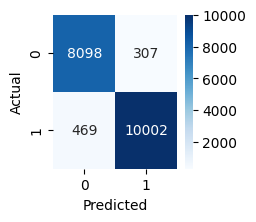

In [129]:
# Make predictions on validation data
y_pred_val_best_model = improved_cat.predict(X_val)
cm = confusion_matrix(y_val, y_pred_val_best_model)
#pretty plot
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels (depends on your problem)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [130]:
[[TN,FP],[FN,TP]] = cm
Accuracy = (TN + TP) / (TN + FP + FN + TP)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
F1_score = 2 * (Precision * Recall) / (Precision + Recall)
maybe_acc = Accuracy - 0.003
target = 0.96
print(f"cm:\n{cm}\nAccuracy:\t{Accuracy:.7f}\nPrecision:\t{Precision:.7f}\nRecall:\t\t{Recall:.7f}\nF1_score:\t{F1_score:.7f}\n\nMaybe Acc:\t{maybe_acc:.7f}\nTarget:\t\t{target:.7f}")


cm:
[[ 8098   307]
 [  469 10002]]
Accuracy:	0.9588896
Precision:	0.9702202
Recall:		0.9552096
F1_score:	0.9626564

Maybe Acc:	0.9558896
Target:		0.9600000


In [131]:
# Make prediction
y_pred_test_improved_cat = improved_cat.predict(test_data)
y_pred_test_improved_cat

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [132]:
results_to_csv(y_pred_test_improved_cat, "y_pred_test_improved_cat")

         ID  Overall_Experience
0  99900001                   1
1  99900002                   1
2  99900003                   1
3  99900004                   0
4  99900005                   1
